# Definitive Version

## Gather all the data

In [3]:
import fastf1
import pandas as pd
import os

#dim reduction preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import numpy as np

In [8]:
year = 2023
#Get the schedule for the year
year_schedule = fastf1.get_event_schedule(year)
print(year_schedule['RoundNumber'])

#Repeat for every race 
for round in year_schedule['RoundNumber'][1:]: #Ignore the first round because it's the testing event of the season, not an actual race

    #Create a dircetory where to store all the files
    dirname = '../data/'+str(round)+'_'+year_schedule['Location'][round]
    os.mkdir(dirname)

    #Get the race and load the data
    race = fastf1.get_session(year, year_schedule['Location'][round], 'R')
    race.load()

    #Laps
    race.laps.to_csv(dirname+'/laps.csv')
    #Results
    race.results.to_csv(dirname+'/results.csv')
    #Race info (unused)
    race.event.to_csv(dirname+'/race_info.csv')
    #Weahter data (unused)
    race.weather_data.to_csv(dirname+'/weather_data.csv')
    #Track status
    race.track_status.to_csv(dirname+'/track_status.csv')
    
    #Create a subdirectory for the car telemetries
    for i in race.car_data.keys():
        race.car_data[i].to_csv(dirname+'/'+str(i)+'_telemetry.csv')


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
Name: RoundNumber, dtype: int32


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req

## Compute PCA


In [13]:
import fastf1
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler

year = 2023
year_schedule = fastf1.get_event_schedule(year)
for round in year_schedule['RoundNumber'][1:]:
       race = fastf1.get_session(year, year_schedule['Location'][round], 'R')
       race.load()

       dataset = race.laps
       # find the rows with pit in time not null
       rows_to_remove = dataset.index[dataset['PitInTime'].notnull()].tolist()
       dataset = dataset.drop(rows_to_remove, axis = 0)
       rows_to_remove = dataset.index[dataset['PitOutTime'].notnull()].tolist()
       dataset = dataset.drop(rows_to_remove, axis = 0)
       cols_to_remove =['DriverNumber','PitOutTime','PitInTime','IsPersonalBest',
                        'FreshTyre','LapStartTime', 'Position', 'Deleted','DeletedReason',
                        'FastF1Generated','IsAccurate']
       dataset = dataset.drop(cols_to_remove, axis = 1)
       dataset['TrackStatus'] = dataset['TrackStatus'].astype('float') #I hate this
       rows_to_remove = dataset.index[dataset['TrackStatus'] != 1].tolist()
       dataset = dataset.drop(rows_to_remove, axis = 0)
       


       #drop rows with missing data because i cant think of something better
       dataset = dataset.dropna(axis=0)
       #drop trackStatus as well after i used i to remove the rows i wanted
       dataset = dataset.drop('TrackStatus', axis = 1)
       #Convert timedelta64 to seconds
       cols_to_change = ['LapTime','Sector1Time',
              'Sector2Time', 'Sector3Time']
       for col in cols_to_change:
              dataset[col] = dataset[col].dt.total_seconds()
       dataset = dataset.reset_index()
       print(dataset.info())
       
       cols = ['LapTime','Sector1Time',
              'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2',
              'SpeedFL', 'SpeedST']

       scaler= StandardScaler()
       scaled = scaler.fit_transform(dataset[cols])

       pca = PCA(n_components = 2)
       components = pca.fit_transform(scaled)
       pca_df = pd.DataFrame(data = components, columns = ['dim1','dim2'])
       #print('\n pca_df: \n', pca_df)

       kmeans = KMeans(n_clusters = 3)
       clusters = kmeans.fit(components)
       labels = kmeans.labels_
       clusters = pd.concat([pca_df, pd.DataFrame({'kmeans_clusters':labels})], axis=1)
       clusters.columns=['dim1','dim2','cluster_id']
       result_df = pd.concat([dataset, clusters], axis=1)
       
       print(f'\n\n\n {year_schedule["Location"][round]} results_df: \n', result_df)

       dirname = '../data/'+str(round)+'_'+year_schedule['Location'][round]
       result_df.to_csv(dirname+'/'+'PCA.csv')


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Saudi Arabian Grand Pri

<class 'fastf1.core.Laps'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               555 non-null    int64          
 1   Time                555 non-null    timedelta64[ns]
 2   Driver              555 non-null    object         
 3   LapTime             555 non-null    float64        
 4   LapNumber           555 non-null    float64        
 5   Stint               555 non-null    float64        
 6   Sector1Time         555 non-null    float64        
 7   Sector2Time         555 non-null    float64        
 8   Sector3Time         555 non-null    float64        
 9   Sector1SessionTime  555 non-null    timedelta64[ns]
 10  Sector2SessionTime  555 non-null    timedelta64[ns]
 11  Sector3SessionTime  555 non-null    timedelta64[ns]
 12  SpeedI1             555 non-null    float64        
 13  SpeedI2             555 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '14', '63', '44', '55', '16', '31', '10', '20', '22', '27', '24', '21', '81', '2', '4', '77', '23', '18']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_

<class 'fastf1.core.Laps'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               595 non-null    int64          
 1   Time                595 non-null    timedelta64[ns]
 2   Driver              595 non-null    object         
 3   LapTime             595 non-null    float64        
 4   LapNumber           595 non-null    float64        
 5   Stint               595 non-null    float64        
 6   Sector1Time         595 non-null    float64        
 7   Sector2Time         595 non-null    float64        
 8   Sector3Time         595 non-null    float64        
 9   Sector1SessionTime  595 non-null    timedelta64[ns]
 10  Sector2SessionTime  595 non-null    timedelta64[ns]
 11  Sector3SessionTime  595 non-null    timedelta64[ns]
 12  SpeedI1             595 non-null    float64        
 13  SpeedI2             595 non-null    float64   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data


<class 'fastf1.core.Laps'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               561 non-null    int64          
 1   Time                561 non-null    timedelta64[ns]
 2   Driver              561 non-null    object         
 3   LapTime             561 non-null    float64        
 4   LapNumber           561 non-null    float64        
 5   Stint               561 non-null    float64        
 6   Sector1Time         561 non-null    float64        
 7   Sector2Time         561 non-null    float64        
 8   Sector3Time         561 non-null    float64        
 9   Sector1SessionTime  561 non-null    timedelta64[ns]
 10  Sector2SessionTime  561 non-null    timedelta64[ns]
 11  Sector3SessionTime  561 non-null    timedelta64[ns]
 12  SpeedI1             561 non-null    float64        
 13  SpeedI2             561 non-null    float64   

req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '16', '14', '55', '44', '18', '63', '4', '22', '81', '23', '20', '10', '31', '2', '27', '77', '24', '21']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               739 non-null    int64          
 1   Time                739 non-null    timedelta64[ns]
 2   Driver              739 non-null    object         
 3   LapTime             739 non-null    float64        
 4   LapNumber           739 non-null    float64        
 5   Stint               739 non-null    float64        
 6   Sector1Time         739 non-null    float64        
 7   Sector2Time         739 non-null    float64        
 8   Sector3Time         739 non-null    float64        
 9   Sector1SessionTime  739 non-null    timedelta64[ns]
 10  Sector2SessionTime  739 non-null    timedelta64[ns]
 11  Sector3SessionTime  739 non-null    timedelta64[ns]
 12  SpeedI1             739 non-null    float64        
 13  SpeedI2             739 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.2.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


<class 'fastf1.core.Laps'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               871 non-null    int64          
 1   Time                871 non-null    timedelta64[ns]
 2   Driver              871 non-null    object         
 3   LapTime             871 non-null    float64        
 4   LapNumber           871 non-null    float64        
 5   Stint               871 non-null    float64        
 6   Sector1Time         871 non-null    float64        
 7   Sector2Time         871 non-null    float64        
 8   Sector3Time         871 non-null    float64        
 9   Sector1SessionTime  871 non-null    timedelta64[ns]
 10  Sector2SessionTime  871 non-null    timedelta64[ns]
 11  Sector3SessionTime  871 non-null    timedelta64[ns]
 12  SpeedI1             871 non-null    float64        
 13  SpeedI2             871 non-null    float64   

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

<class 'fastf1.core.Laps'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               1147 non-null   int64          
 1   Time                1147 non-null   timedelta64[ns]
 2   Driver              1147 non-null   object         
 3   LapTime             1147 non-null   float64        
 4   LapNumber           1147 non-null   float64        
 5   Stint               1147 non-null   float64        
 6   Sector1Time         1147 non-null   float64        
 7   Sector2Time         1147 non-null   float64        
 8   Sector3Time         1147 non-null   float64        
 9   Sector1SessionTime  1147 non-null   timedelta64[ns]
 10  Sector2SessionTime  1147 non-null   timedelta64[ns]
 11  Sector3SessionTime  1147 non-null   timedelta64[ns]
 12  SpeedI1             1147 non-null   float64        
 13  SpeedI2             1147 non-null   float64 

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               820 non-null    int64          
 1   Time                820 non-null    timedelta64[ns]
 2   Driver              820 non-null    object         
 3   LapTime             820 non-null    float64        
 4   LapNumber           820 non-null    float64        
 5   Stint               820 non-null    float64        
 6   Sector1Time         820 non-null    float64        
 7   Sector2Time         820 non-null    float64        
 8   Sector3Time         820 non-null    float64        
 9   Sector1SessionTime  820 non-null    timedelta64[ns]
 10  Sector2SessionTime  820 non-null    timedelta64[ns]
 11  Sector3SessionTime  820 non-null    timedelta64[ns]
 12  SpeedI1             820 non-null    float64        
 13  SpeedI2             820 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '44', '16', '55', '11', '23', '31', '18', '77', '81', '10', '4', '22', '27', '24', '20', '21', '63', '2']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               829 non-null    int64          
 1   Time                829 non-null    timedelta64[ns]
 2   Driver              829 non-null    object         
 3   LapTime             829 non-null    float64        
 4   LapNumber           829 non-null    float64        
 5   Stint               829 non-null    float64        
 6   Sector1Time         829 non-null    float64        
 7   Sector2Time         829 non-null    float64        
 8   Sector3Time         829 non-null    float64        
 9   Sector1SessionTime  829 non-null    timedelta64[ns]
 10  Sector2SessionTime  829 non-null    timedelta64[ns]
 11  Sector3SessionTime  829 non-null    timedelta64[ns]
 12  SpeedI1             829 non-null    float64        
 13  SpeedI2             829 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '4', '14', '55', '63', '44', '18', '10', '23', '24', '2', '31', '77', '81', '21', '20', '22', '27']
core           INFO 	Loading data for British Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               990 non-null    int64          
 1   Time                990 non-null    timedelta64[ns]
 2   Driver              990 non-null    object         
 3   LapTime             990 non-null    float64        
 4   LapNumber           990 non-null    float64        
 5   Stint               990 non-null    float64        
 6   Sector1Time         990 non-null    float64        
 7   Sector2Time         990 non-null    float64        
 8   Sector3Time         990 non-null    float64        
 9   Sector1SessionTime  990 non-null    timedelta64[ns]
 10  Sector2SessionTime  990 non-null    timedelta64[ns]
 11  Sector3SessionTime  990 non-null    timedelta64[ns]
 12  SpeedI1             990 non-null    float64        
 13  SpeedI2             990 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               637 non-null    int64          
 1   Time                637 non-null    timedelta64[ns]
 2   Driver              637 non-null    object         
 3   LapTime             637 non-null    float64        
 4   LapNumber           637 non-null    float64        
 5   Stint               637 non-null    float64        
 6   Sector1Time         637 non-null    float64        
 7   Sector2Time         637 non-null    float64        
 8   Sector3Time         637 non-null    float64        
 9   Sector1SessionTime  637 non-null    timedelta64[ns]
 10  Sector2SessionTime  637 non-null    timedelta64[ns]
 11  Sector3SessionTime  637 non-null    timedelta64[ns]
 12  SpeedI1             637 non-null    float64        
 13  SpeedI2             637 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '44', '81', '63', '16', '55', '14', '18', '23', '77', '3', '27', '22', '24', '20', '2', '31', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               680 non-null    int64          
 1   Time                680 non-null    timedelta64[ns]
 2   Driver              680 non-null    object         
 3   LapTime             680 non-null    float64        
 4   LapNumber           680 non-null    float64        
 5   Stint               680 non-null    float64        
 6   Sector1Time         680 non-null    float64        
 7   Sector2Time         680 non-null    float64        
 8   Sector3Time         680 non-null    float64        
 9   Sector1SessionTime  680 non-null    timedelta64[ns]
 10  Sector2SessionTime  680 non-null    timedelta64[ns]
 11  Sector3SessionTime  680 non-null    timedelta64[ns]
 12  SpeedI1             680 non-null    float64        
 13  SpeedI2             680 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '44', '14', '63', '4', '31', '18', '22', '10', '77', '24', '23', '20', '3', '2', '27', '55', '81']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               486 non-null    int64          
 1   Time                486 non-null    timedelta64[ns]
 2   Driver              486 non-null    object         
 3   LapTime             486 non-null    float64        
 4   LapNumber           486 non-null    float64        
 5   Stint               486 non-null    float64        
 6   Sector1Time         486 non-null    float64        
 7   Sector2Time         486 non-null    float64        
 8   Sector3Time         486 non-null    float64        
 9   Sector1SessionTime  486 non-null    timedelta64[ns]
 10  Sector2SessionTime  486 non-null    timedelta64[ns]
 11  Sector3SessionTime  486 non-null    timedelta64[ns]
 12  SpeedI1             486 non-null    float64        
 13  SpeedI2             486 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               675 non-null    int64          
 1   Time                675 non-null    timedelta64[ns]
 2   Driver              675 non-null    object         
 3   LapTime             675 non-null    float64        
 4   LapNumber           675 non-null    float64        
 5   Stint               675 non-null    float64        
 6   Sector1Time         675 non-null    float64        
 7   Sector2Time         675 non-null    float64        
 8   Sector3Time         675 non-null    float64        
 9   Sector1SessionTime  675 non-null    timedelta64[ns]
 10  Sector2SessionTime  675 non-null    timedelta64[ns]
 11  Sector3SessionTime  675 non-null    timedelta64[ns]
 12  SpeedI1             675 non-null    float64        
 13  SpeedI2             675 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '44', '23', '4', '14', '77', '40', '81', '2', '24', '10', '18', '27', '20', '31', '22']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               660 non-null    int64          
 1   Time                660 non-null    timedelta64[ns]
 2   Driver              660 non-null    object         
 3   LapTime             660 non-null    float64        
 4   LapNumber           660 non-null    float64        
 5   Stint               660 non-null    float64        
 6   Sector1Time         660 non-null    float64        
 7   Sector2Time         660 non-null    float64        
 8   Sector3Time         660 non-null    float64        
 9   Sector1SessionTime  660 non-null    timedelta64[ns]
 10  Sector2SessionTime  660 non-null    timedelta64[ns]
 11  Sector3SessionTime  660 non-null    timedelta64[ns]
 12  SpeedI1             660 non-null    float64        
 13  SpeedI2             660 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '44', '16', '1', '10', '81', '11', '40', '20', '23', '24', '27', '2', '14', '63', '77', '31', '22', '18']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.2.0]
req            INFO 	U

<class 'fastf1.core.Laps'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               620 non-null    int64          
 1   Time                620 non-null    timedelta64[ns]
 2   Driver              620 non-null    object         
 3   LapTime             620 non-null    float64        
 4   LapNumber           620 non-null    float64        
 5   Stint               620 non-null    float64        
 6   Sector1Time         620 non-null    float64        
 7   Sector2Time         620 non-null    float64        
 8   Sector3Time         620 non-null    float64        
 9   Sector1SessionTime  620 non-null    timedelta64[ns]
 10  Sector2SessionTime  620 non-null    timedelta64[ns]
 11  Sector3SessionTime  620 non-null    timedelta64[ns]
 12  SpeedI1             620 non-null    float64        
 13  SpeedI2             620 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '55', '63', '14', '31', '10', '40', '22', '24', '27', '20', '23', '2', '18', '11', '77']
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               544 non-null    int64          
 1   Time                544 non-null    timedelta64[ns]
 2   Driver              544 non-null    object         
 3   LapTime             544 non-null    float64        
 4   LapNumber           544 non-null    float64        
 5   Stint               544 non-null    float64        
 6   Sector1Time         544 non-null    float64        
 7   Sector2Time         544 non-null    float64        
 8   Sector3Time         544 non-null    float64        
 9   Sector1SessionTime  544 non-null    timedelta64[ns]
 10  Sector2SessionTime  544 non-null    timedelta64[ns]
 11  Sector3SessionTime  544 non-null    timedelta64[ns]
 12  SpeedI1             544 non-null    float64        
 13  SpeedI2             544 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '63', '16', '14', '31', '77', '24', '11', '18', '10', '23', '20', '22', '27', '40', '2', '44', '55']
core           INFO 	Loading data for United States Grand Prix - Race [v3.2.0]
req            IN

<class 'fastf1.core.Laps'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               570 non-null    int64          
 1   Time                570 non-null    timedelta64[ns]
 2   Driver              570 non-null    object         
 3   LapTime             570 non-null    float64        
 4   LapNumber           570 non-null    float64        
 5   Stint               570 non-null    float64        
 6   Sector1Time         570 non-null    float64        
 7   Sector2Time         570 non-null    float64        
 8   Sector3Time         570 non-null    float64        
 9   Sector1SessionTime  570 non-null    timedelta64[ns]
 10  Sector2SessionTime  570 non-null    timedelta64[ns]
 11  Sector3SessionTime  570 non-null    timedelta64[ns]
 12  SpeedI1             570 non-null    float64        
 13  SpeedI2             570 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '14', '81', '31', '44', '16']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               798 non-null    int64          
 1   Time                798 non-null    timedelta64[ns]
 2   Driver              798 non-null    object         
 3   LapTime             798 non-null    float64        
 4   LapNumber           798 non-null    float64        
 5   Stint               798 non-null    float64        
 6   Sector1Time         798 non-null    float64        
 7   Sector2Time         798 non-null    float64        
 8   Sector3Time         798 non-null    float64        
 9   Sector1SessionTime  798 non-null    timedelta64[ns]
 10  Sector2SessionTime  798 non-null    timedelta64[ns]
 11  Sector3SessionTime  798 non-null    timedelta64[ns]
 12  SpeedI1             798 non-null    float64        
 13  SpeedI2             798 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '55', '4', '63', '3', '81', '23', '31', '10', '22', '27', '24', '77', '2', '18', '14', '20', '11']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


<class 'fastf1.core.Laps'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               834 non-null    int64          
 1   Time                834 non-null    timedelta64[ns]
 2   Driver              834 non-null    object         
 3   LapTime             834 non-null    float64        
 4   LapNumber           834 non-null    float64        
 5   Stint               834 non-null    float64        
 6   Sector1Time         834 non-null    float64        
 7   Sector2Time         834 non-null    float64        
 8   Sector3Time         834 non-null    float64        
 9   Sector1SessionTime  834 non-null    timedelta64[ns]
 10  Sector2SessionTime  834 non-null    timedelta64[ns]
 11  Sector3SessionTime  834 non-null    timedelta64[ns]
 12  SpeedI1             834 non-null    float64        
 13  SpeedI2             834 non-null    float64   

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '14', '11', '18', '55', '10', '44', '22', '31', '2', '27', '3', '81', '63', '77', '24', '20', '23', '16']
core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_da

<class 'fastf1.core.Laps'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               729 non-null    int64          
 1   Time                729 non-null    timedelta64[ns]
 2   Driver              729 non-null    object         
 3   LapTime             729 non-null    float64        
 4   LapNumber           729 non-null    float64        
 5   Stint               729 non-null    float64        
 6   Sector1Time         729 non-null    float64        
 7   Sector2Time         729 non-null    float64        
 8   Sector3Time         729 non-null    float64        
 9   Sector1SessionTime  729 non-null    timedelta64[ns]
 10  Sector2SessionTime  729 non-null    timedelta64[ns]
 11  Sector3SessionTime  729 non-null    timedelta64[ns]
 12  SpeedI1             729 non-null    float64        
 13  SpeedI2             729 non-null    float64   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '31', '18', '55', '44', '63', '14', '81', '10', '23', '20', '3', '24', '2', '77', '22', '27', '4']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


<class 'fastf1.core.Laps'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               540 non-null    int64          
 1   Time                540 non-null    timedelta64[ns]
 2   Driver              540 non-null    object         
 3   LapTime             540 non-null    float64        
 4   LapNumber           540 non-null    float64        
 5   Stint               540 non-null    float64        
 6   Sector1Time         540 non-null    float64        
 7   Sector2Time         540 non-null    float64        
 8   Sector3Time         540 non-null    float64        
 9   Sector1SessionTime  540 non-null    timedelta64[ns]
 10  Sector2SessionTime  540 non-null    timedelta64[ns]
 11  Sector3SessionTime  540 non-null    timedelta64[ns]
 12  SpeedI1             540 non-null    float64        
 13  SpeedI2             540 non-null    float64   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '11', '4', '81', '14', '22', '44', '18', '3', '31', '10', '23', '27', '2', '24', '55', '77', '20']


<class 'fastf1.core.Laps'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   index               809 non-null    int64          
 1   Time                809 non-null    timedelta64[ns]
 2   Driver              809 non-null    object         
 3   LapTime             809 non-null    float64        
 4   LapNumber           809 non-null    float64        
 5   Stint               809 non-null    float64        
 6   Sector1Time         809 non-null    float64        
 7   Sector2Time         809 non-null    float64        
 8   Sector3Time         809 non-null    float64        
 9   Sector1SessionTime  809 non-null    timedelta64[ns]
 10  Sector2SessionTime  809 non-null    timedelta64[ns]
 11  Sector3SessionTime  809 non-null    timedelta64[ns]
 12  SpeedI1             809 non-null    float64        
 13  SpeedI2             809 non-null    float64   

# Compute t-SNE

In [15]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
import fastf1

year = 2023
year_schedule = fastf1.get_event_schedule(year)
for round in year_schedule['RoundNumber'][1:]:
       race = fastf1.get_session(year, year_schedule['Location'][round], 'R')
       race.load()

       dataset = race.laps
       rows_to_remove = dataset.index[dataset['PitInTime'].notnull()].tolist()
       dataset = dataset.drop(rows_to_remove, axis = 0)
       rows_to_remove = dataset.index[dataset['PitOutTime'].notnull()].tolist()
       dataset = dataset.drop(rows_to_remove, axis = 0)
       cols_to_remove =['Time', 'DriverNumber','PitOutTime','PitInTime', 'Sector1SessionTime', 
                        'Sector2SessionTime', 'Sector3SessionTime', 'IsPersonalBest',
                        'FreshTyre','LapStartTime','LapStartDate', 'Deleted',
                        'DeletedReason','FastF1Generated','IsAccurate']
       dataset = dataset.drop(cols_to_remove, axis = 1)
       dataset['TrackStatus'] = dataset['TrackStatus'].astype('float') #I hate this
       #drop rows where track status is not 1, i.e. the lap is not a 'racing' lap
       rows_to_remove = dataset.index[dataset['TrackStatus'] != 1].tolist()
       dataset = dataset.drop(rows_to_remove, axis = 0)

       #drop rows with missing data because i cant think of something better
       dataset = dataset.dropna(axis=0)
       #drop trackStatus as well after i used i to remove the rows i wanted
       dataset = dataset.drop('TrackStatus', axis = 1)
       #Convert timedelta64 to seconds
       cols_to_change = ['LapTime','Sector1Time',
              'Sector2Time', 'Sector3Time']
       for col in cols_to_change:
              dataset[col] = dataset[col].dt.total_seconds()
       dataset = dataset.reset_index()
       print(dataset.info())
       
       cols = ['LapTime', 'Sector1Time',
              'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2',
              'SpeedFL', 'SpeedST']
       scaler= StandardScaler()
       scaler.fit(dataset[cols])
       scaled = scaler.fit_transform(dataset[cols])
       print(scaled)
       RS = 16
       tsne = TSNE(n_components=2, learning_rate = 250, n_iter=5000,
                   n_iter_without_progress=500, random_state=RS)
       tsne_results = tsne.fit_transform(scaled)
       tsne_df = pd.DataFrame(data = tsne_results, columns=['dim1','dim2'])
       print(tsne_df)

       #KMeans
       k_means_tsne = KMeans(n_clusters=3, n_init=100, max_iter=400, init="k-means++", random_state=RS).fit(tsne_df)
       labels_tsne = k_means_tsne.labels_
       clusters_tsne = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne})], axis=1)
       clusters_tsne.columns=['dim1','dim2','tsne_clusters_id']
       print(clusters_tsne)
       print(clusters_tsne['tsne_clusters_id'].value_counts())

       result_df = pd.concat([dataset, clusters_tsne], axis=1)
       print(result_df)

       dirname = '../data/'+str(round)+'_'+year_schedule['Location'][round]
       result_df.to_csv(dirname+'/'+'tSNE.csv')

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


<class 'fastf1.core.Laps'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        557 non-null    int64  
 1   Driver       557 non-null    object 
 2   LapTime      557 non-null    float64
 3   LapNumber    557 non-null    float64
 4   Stint        557 non-null    float64
 5   Sector1Time  557 non-null    float64
 6   Sector2Time  557 non-null    float64
 7   Sector3Time  557 non-null    float64
 8   SpeedI1      557 non-null    float64
 9   SpeedI2      557 non-null    float64
 10  SpeedFL      557 non-null    float64
 11  SpeedST      557 non-null    float64
 12  Compound     557 non-null    object 
 13  TyreLife     557 non-null    float64
 14  Team         557 non-null    object 
 15  Position     557 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 69.8+ KB
None
[[-0.46465212 -0.18200459 -0.5635408  ... -1.28500036 -1.14911079
  -1.56921783]


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0     8.949662  13.605425                 0
1     8.310855  13.078983                 0
2     8.780295  12.448375                 0
3     4.446888  14.191765                 0
4     5.504676  14.162457                 0
..         ...        ...               ...
552 -34.714706   6.259804                 1
553 -34.677441   7.311219                 1
554 -30.298109   8.782324                 1
555 -28.100147  15.464427                 1
556 -23.114443  19.890306                 1

[557 rows x 3 columns]
tsne_clusters_id
0    216
1    209
2    132
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        3    VER   97.976        4.0    1.0       31.271       42.642   
1        5    VER   97.986        6.0    1.0       31.341       42.632   
2        6    VER   98.021        7.0    1.0       31.290       42.763   
3       11    VER   98.591       12.0    1.0       31.408       42.951   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '14', '63', '44', '55', '16', '31', '10', '20', '22', '27', '24', '21', '81', '2', '4', '77', '23', '18']


<class 'fastf1.core.Laps'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        595 non-null    int64  
 1   Driver       595 non-null    object 
 2   LapTime      595 non-null    float64
 3   LapNumber    595 non-null    float64
 4   Stint        595 non-null    float64
 5   Sector1Time  595 non-null    float64
 6   Sector2Time  595 non-null    float64
 7   Sector3Time  595 non-null    float64
 8   SpeedI1      595 non-null    float64
 9   SpeedI2      595 non-null    float64
 10  SpeedFL      595 non-null    float64
 11  SpeedST      595 non-null    float64
 12  Compound     595 non-null    object 
 13  TyreLife     595 non-null    float64
 14  Team         595 non-null    object 
 15  Position     595 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 74.5+ KB
None
[[ 1.77067392  1.70668647  1.8422427  ...  0.36095199  0.04398932
   0.94090601]


core           INFO 	Loading data for Australian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']


<class 'fastf1.core.Laps'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        563 non-null    int64  
 1   Driver       563 non-null    object 
 2   LapTime      563 non-null    float64
 3   LapNumber    563 non-null    float64
 4   Stint        563 non-null    float64
 5   Sector1Time  563 non-null    float64
 6   Sector2Time  563 non-null    float64
 7   Sector3Time  563 non-null    float64
 8   SpeedI1      563 non-null    float64
 9   SpeedI2      563 non-null    float64
 10  SpeedFL      563 non-null    float64
 11  SpeedST      563 non-null    float64
 12  Compound     563 non-null    object 
 13  TyreLife     563 non-null    float64
 14  Team         563 non-null    object 
 15  Position     563 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 70.5+ KB
None
[[ 0.07250681 -0.11925304 -0.13597519 ... -0.40894271 -0.36780718
   0.64422269]


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        3    VER   83.391        4.0    1.0       28.900       18.326   
1        4    VER   83.104        5.0    1.0       28.935       18.347   
2        5    VER   82.843        6.0    1.0       28.986       17.951   
3        9    VER   87.827       10.0    2.0       33.323       18.633   
4       10    VER   83.460       11.0    2.0       29.054       18.556   
..     ...    ...      ...        ...    ...          ...          ...   
558    992    PIA   81.686       48.0    2.0       28.552       18.496   
559    993    PIA   81.525       49.0    2.0       28.394       18.467   
560    994    PIA   81.752       50.0    2.0       28.522       18.478   
561    995    PIA   81.737       51.0    2.0       28.411       18.485   
562    996    PIA   81.683       52.0    2.0       28.577       18.388   

     Sector3Time  SpeedI1  SpeedI2  SpeedFL  SpeedST Compound  TyreLife  \
0         36.165    280.0    296.0  

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '16', '14', '55', '44', '18', '63', '4', '22', '81', '23', '20', '10', '31', '2', '27', '77', '24', '21']


<class 'fastf1.core.Laps'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        740 non-null    int64  
 1   Driver       740 non-null    object 
 2   LapTime      740 non-null    float64
 3   LapNumber    740 non-null    float64
 4   Stint        740 non-null    float64
 5   Sector1Time  740 non-null    float64
 6   Sector2Time  740 non-null    float64
 7   Sector3Time  740 non-null    float64
 8   SpeedI1      740 non-null    float64
 9   SpeedI2      740 non-null    float64
 10  SpeedFL      740 non-null    float64
 11  SpeedST      740 non-null    float64
 12  Compound     740 non-null    object 
 13  TyreLife     740 non-null    float64
 14  Team         740 non-null    object 
 15  Position     740 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 92.6+ KB
None
[[ 0.34656011  0.32474758 -0.00666765 ...  0.36896603 -0.98642966
   0.11388847]


core           INFO 	Loading data for Miami Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0    -3.158207  10.299579                 0
1    17.216120  -4.805326                 2
2    -8.153708  21.727222                 0
3    -9.028944  22.075293                 0
4    -8.874540  20.785219                 0
..         ...        ...               ...
735  -2.131190 -11.719585                 2
736   9.601254 -13.111183                 2
737 -18.814503  11.389652                 1
738 -18.264988  -4.746376                 1
739 -25.899746  -5.301347                 1

[740 rows x 3 columns]
tsne_clusters_id
1    283
2    241
0    216
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        1    VER  107.707        2.0    1.0       38.431       43.642   
1        2    VER  107.677        3.0    1.0       38.493       43.718   
2        3    VER  107.108        4.0    1.0       37.933       43.372   
3        4    VER  107.476        5.0    1.0       38.284       43.414   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']


<class 'fastf1.core.Laps'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        872 non-null    int64  
 1   Driver       872 non-null    object 
 2   LapTime      872 non-null    float64
 3   LapNumber    872 non-null    float64
 4   Stint        872 non-null    float64
 5   Sector1Time  872 non-null    float64
 6   Sector2Time  872 non-null    float64
 7   Sector3Time  872 non-null    float64
 8   SpeedI1      872 non-null    float64
 9   SpeedI2      872 non-null    float64
 10  SpeedFL      872 non-null    float64
 11  SpeedST      872 non-null    float64
 12  Compound     872 non-null    object 
 13  TyreLife     872 non-null    float64
 14  Team         872 non-null    object 
 15  Position     872 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 109.1+ KB
None
[[ 1.41563193  1.35272625  1.87623364 ... -1.71430636  2.76152233
  -2.46879549]

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0    26.153511 -34.031017                 1
1    -7.645807   5.073485                 2
2    16.534559  17.770716                 2
3    14.685895  18.694227                 2
4     5.292519 -11.420664                 1
..         ...        ...               ...
867   4.131964  10.439783                 2
868  -2.943656 -43.255310                 1
869  15.746821  -8.683016                 1
870  18.939186 -11.822299                 1
871  -2.605041 -44.226105                 1

[872 rows x 3 columns]
tsne_clusters_id
2    321
1    316
0    235
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        2    VER   94.127        3.0    1.0       32.337       35.896   
1        3    VER   92.935        4.0    1.0       32.042       34.996   
2        5    VER   92.753        6.0    1.0       31.893       35.037   
3        6    VER   92.555        7.0    1.0       31.915       34.921   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']


<class 'fastf1.core.Laps'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        1149 non-null   int64  
 1   Driver       1149 non-null   object 
 2   LapTime      1149 non-null   float64
 3   LapNumber    1149 non-null   float64
 4   Stint        1149 non-null   float64
 5   Sector1Time  1149 non-null   float64
 6   Sector2Time  1149 non-null   float64
 7   Sector3Time  1149 non-null   float64
 8   SpeedI1      1149 non-null   float64
 9   SpeedI2      1149 non-null   float64
 10  SpeedFL      1149 non-null   float64
 11  SpeedST      1149 non-null   float64
 12  Compound     1149 non-null   object 
 13  TyreLife     1149 non-null   float64
 14  Team         1149 non-null   object 
 15  Position     1149 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 143.8+ KB
None
[[-0.45338411 -0.35947882 -0.49827662 ...  0.25722553 -0.35484238
  -1.5206377

core           INFO 	Loading data for Spanish Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


           dim1       dim2  tsne_clusters_id
0     14.799370  31.374018                 0
1     14.944038  32.053860                 0
2     14.060551  32.104176                 0
3     13.717222  31.674570                 0
4     14.528195  32.927509                 0
...         ...        ...               ...
1144  42.291588  -5.338182                 1
1145  39.882828  -6.388892                 1
1146  38.838257  -6.681326                 1
1147  38.397907  -7.440769                 1
1148  37.574684  -6.395481                 1

[1149 rows x 3 columns]
tsne_clusters_id
0    621
1    330
2    198
Name: count, dtype: int64
      index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0         1    VER   79.367        2.0    1.0       20.954       37.366   
1         2    VER   79.074        3.0    1.0       20.854       37.288   
2         3    VER   78.129        4.0    1.0       20.835       36.637   
3         4    VER   78.019        5.0    1.0       20.745       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']


<class 'fastf1.core.Laps'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        821 non-null    int64  
 1   Driver       821 non-null    object 
 2   LapTime      821 non-null    float64
 3   LapNumber    821 non-null    float64
 4   Stint        821 non-null    float64
 5   Sector1Time  821 non-null    float64
 6   Sector2Time  821 non-null    float64
 7   Sector3Time  821 non-null    float64
 8   SpeedI1      821 non-null    float64
 9   SpeedI2      821 non-null    float64
 10  SpeedFL      821 non-null    float64
 11  SpeedST      821 non-null    float64
 12  Compound     821 non-null    object 
 13  TyreLife     821 non-null    float64
 14  Team         821 non-null    object 
 15  Position     821 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 102.8+ KB
None
[[ 0.16648755  0.9195576  -0.2621635  ... -1.359171   -0.82587067
  -1.35715777]

core           INFO 	Loading data for Canadian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0    20.974733 -35.798935                 1
1    21.495462 -35.975098                 1
2    21.399076 -34.748573                 1
3    21.905878 -34.955639                 1
4    17.317461 -30.790648                 1
..         ...        ...               ...
816  -3.560297  -7.692841                 1
817  11.979975 -34.782021                 1
818  36.220669   3.683769                 2
819   5.343098  -8.186922                 1
820  -4.809503 -10.122284                 1

[821 rows x 3 columns]
tsne_clusters_id
1    317
0    317
2    187
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        1    VER   80.402        2.0    1.0       24.186       32.088   
1        2    VER   80.499        3.0    1.0       24.167       32.191   
2        3    VER   80.346        4.0    1.0       24.022       32.159   
3        4    VER   80.283        5.0    1.0       24.034       32.213   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '44', '16', '55', '11', '23', '31', '18', '77', '81', '10', '4', '22', '27', '24', '20', '21', '63', '2']


<class 'fastf1.core.Laps'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        831 non-null    int64  
 1   Driver       831 non-null    object 
 2   LapTime      831 non-null    float64
 3   LapNumber    831 non-null    float64
 4   Stint        831 non-null    float64
 5   Sector1Time  831 non-null    float64
 6   Sector2Time  831 non-null    float64
 7   Sector3Time  831 non-null    float64
 8   SpeedI1      831 non-null    float64
 9   SpeedI2      831 non-null    float64
 10  SpeedFL      831 non-null    float64
 11  SpeedST      831 non-null    float64
 12  Compound     831 non-null    object 
 13  TyreLife     831 non-null    float64
 14  Team         831 non-null    object 
 15  Position     831 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 104.0+ KB
None
[[ 0.48291031 -0.13766208  0.70306933 ... -2.00170861 -1.36973525
  -1.08156965]

core           INFO 	Loading data for Austrian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0    13.788570 -21.950930                 1
1    14.188734 -19.902042                 1
2    25.237938 -18.761395                 1
3    18.256907 -21.963327                 1
4    18.898932 -22.617422                 1
..         ...        ...               ...
826  -9.537612  13.115767                 0
827 -30.535542  24.703104                 2
828 -32.101933  23.775465                 2
829 -31.791573  22.667467                 2
830 -36.210907  17.865627                 2

[831 rows x 3 columns]
tsne_clusters_id
1    292
0    275
2    264
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        1    VER   78.075        2.0    1.0       21.686       25.051   
1        2    VER   77.767        3.0    1.0       21.626       24.909   
2        3    VER   77.203        4.0    1.0       21.438       24.716   
3        5    VER   77.607        6.0    1.0       21.609       24.763   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '4', '14', '55', '63', '44', '18', '10', '23', '24', '2', '31', '77', '81', '21', '20', '22', '27']


<class 'fastf1.core.Laps'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        992 non-null    int64  
 1   Driver       992 non-null    object 
 2   LapTime      992 non-null    float64
 3   LapNumber    992 non-null    float64
 4   Stint        992 non-null    float64
 5   Sector1Time  992 non-null    float64
 6   Sector2Time  992 non-null    float64
 7   Sector3Time  992 non-null    float64
 8   SpeedI1      992 non-null    float64
 9   SpeedI2      992 non-null    float64
 10  SpeedFL      992 non-null    float64
 11  SpeedST      992 non-null    float64
 12  Compound     992 non-null    object 
 13  TyreLife     992 non-null    float64
 14  Team         992 non-null    object 
 15  Position     992 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 124.1+ KB
None
[[-0.85309522  0.19325436 -1.14959907 ...  0.62632871 -1.25367058
  -0.09296529]

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
core           INFO 	Loading data for British Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 3
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 3)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cach

<class 'fastf1.core.Laps'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        639 non-null    int64  
 1   Driver       639 non-null    object 
 2   LapTime      639 non-null    float64
 3   LapNumber    639 non-null    float64
 4   Stint        639 non-null    float64
 5   Sector1Time  639 non-null    float64
 6   Sector2Time  639 non-null    float64
 7   Sector3Time  639 non-null    float64
 8   SpeedI1      639 non-null    float64
 9   SpeedI2      639 non-null    float64
 10  SpeedFL      639 non-null    float64
 11  SpeedST      639 non-null    float64
 12  Compound     639 non-null    object 
 13  TyreLife     639 non-null    float64
 14  Team         639 non-null    object 
 15  Position     639 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 80.0+ KB
None
[[ 0.36295945 -0.11406997  0.59882459 ... -0.4008277  -0.41793642
  -1.29213647]


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '44', '81', '63', '16', '55', '14', '18', '23', '77', '3', '27', '22', '24', '20', '2', '31', '10']


<class 'fastf1.core.Laps'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        681 non-null    int64  
 1   Driver       681 non-null    object 
 2   LapTime      681 non-null    float64
 3   LapNumber    681 non-null    float64
 4   Stint        681 non-null    float64
 5   Sector1Time  681 non-null    float64
 6   Sector2Time  681 non-null    float64
 7   Sector3Time  681 non-null    float64
 8   SpeedI1      681 non-null    float64
 9   SpeedI2      681 non-null    float64
 10  SpeedFL      681 non-null    float64
 11  SpeedST      681 non-null    float64
 12  Compound     681 non-null    object 
 13  TyreLife     681 non-null    float64
 14  Team         681 non-null    object 
 15  Position     681 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 85.2+ KB
None
[[ 0.42082747  0.36910618  0.6927409  ... -1.6034266  -0.79713111
  -1.04246245]


core           INFO 	Loading data for Belgian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0    -1.130415 -30.061491                 0
1    -1.308751 -31.310480                 0
2    -0.549036 -30.809616                 0
3     7.491187 -24.371243                 0
4     8.340030 -23.216990                 0
..         ...        ...               ...
676 -26.354044 -10.901417                 1
677 -20.878788  11.576404                 1
678  -0.686309  -0.313441                 0
679 -22.308508 -26.589140                 0
680 -25.445660  14.883266                 1

[681 rows x 3 columns]
tsne_clusters_id
2    291
0    282
1    108
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        1    VER   85.157        2.0    1.0       30.527       30.848   
1        2    VER   85.070        3.0    1.0       30.491       30.724   
2        4    VER   84.843        5.0    1.0       30.395       30.707   
3        5    VER   84.596        6.0    1.0       30.248       30.586   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '44', '14', '63', '4', '31', '18', '22', '10', '77', '24', '23', '20', '3', '2', '27', '55', '81']


<class 'fastf1.core.Laps'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        486 non-null    int64  
 1   Driver       486 non-null    object 
 2   LapTime      486 non-null    float64
 3   LapNumber    486 non-null    float64
 4   Stint        486 non-null    float64
 5   Sector1Time  486 non-null    float64
 6   Sector2Time  486 non-null    float64
 7   Sector3Time  486 non-null    float64
 8   SpeedI1      486 non-null    float64
 9   SpeedI2      486 non-null    float64
 10  SpeedFL      486 non-null    float64
 11  SpeedST      486 non-null    float64
 12  Compound     486 non-null    object 
 13  TyreLife     486 non-null    float64
 14  Team         486 non-null    object 
 15  Position     486 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 60.9+ KB
None
[[-0.23499344 -1.02258248  0.18662452 ...  0.08913516  0.64014422
   0.10675008]


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']


<class 'fastf1.core.Laps'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        677 non-null    int64  
 1   Driver       677 non-null    object 
 2   LapTime      677 non-null    float64
 3   LapNumber    677 non-null    float64
 4   Stint        677 non-null    float64
 5   Sector1Time  677 non-null    float64
 6   Sector2Time  677 non-null    float64
 7   Sector3Time  677 non-null    float64
 8   SpeedI1      677 non-null    float64
 9   SpeedI2      677 non-null    float64
 10  SpeedFL      677 non-null    float64
 11  SpeedST      677 non-null    float64
 12  Compound     677 non-null    object 
 13  TyreLife     677 non-null    float64
 14  Team         677 non-null    object 
 15  Position     677 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 84.8+ KB
None
[[ 0.79746059  1.16463737  0.57934707 ... -0.03658106 -0.4309062
  -1.269259  ]
 

core           INFO 	Loading data for Italian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '44', '23', '4', '14', '77', '40', '81', '2', '24', '10', '18', '27', '20', '31', '22']


<class 'fastf1.core.Laps'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        661 non-null    int64  
 1   Driver       661 non-null    object 
 2   LapTime      661 non-null    float64
 3   LapNumber    661 non-null    float64
 4   Stint        661 non-null    float64
 5   Sector1Time  661 non-null    float64
 6   Sector2Time  661 non-null    float64
 7   Sector3Time  661 non-null    float64
 8   SpeedI1      661 non-null    float64
 9   SpeedI2      661 non-null    float64
 10  SpeedFL      661 non-null    float64
 11  SpeedST      661 non-null    float64
 12  Compound     661 non-null    object 
 13  TyreLife     661 non-null    float64
 14  Team         661 non-null    object 
 15  Position     661 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 82.8+ KB
None
[[-1.02448563 -0.01262968 -1.22910707 ... -0.89612302 -0.38396292
  -1.54564467]


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0     6.956716 -20.910713                 0
1   -16.545279 -25.096067                 0
2   -18.368999 -20.588730                 0
3   -14.505621   7.576823                 2
4   -14.729386  -9.865131                 0
..         ...        ...               ...
656 -28.148546 -14.604174                 0
657 -23.404060 -21.167416                 0
658 -17.682888   7.588855                 2
659 -20.891008 -14.731994                 0
660  -9.130683 -30.532448                 0

[661 rows x 3 columns]
tsne_clusters_id
0    240
1    213
2    208
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        1    VER   86.163        2.0    1.0       28.274       29.543   
1        2    VER   85.702        3.0    1.0       28.097       29.320   
2        3    VER   86.050        4.0    1.0       28.145       29.474   
3        5    VER   86.837        6.0    1.0       28.700       29.662   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '44', '16', '1', '10', '81', '11', '40', '20', '23', '24', '27', '2', '14', '63', '77', '31', '22', '18']


<class 'fastf1.core.Laps'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        620 non-null    int64  
 1   Driver       620 non-null    object 
 2   LapTime      620 non-null    float64
 3   LapNumber    620 non-null    float64
 4   Stint        620 non-null    float64
 5   Sector1Time  620 non-null    float64
 6   Sector2Time  620 non-null    float64
 7   Sector3Time  620 non-null    float64
 8   SpeedI1      620 non-null    float64
 9   SpeedI2      620 non-null    float64
 10  SpeedFL      620 non-null    float64
 11  SpeedST      620 non-null    float64
 12  Compound     620 non-null    object 
 13  TyreLife     620 non-null    float64
 14  Team         620 non-null    object 
 15  Position     620 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 77.6+ KB
None
[[ 7.88660537e-01  5.80890922e-02  2.54225423e-01 ...  1.18511330e+00
  -3.256580

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -18.476406   7.377874                 2
1    -6.177209  13.508047                 2
2    -6.789013 -20.996210                 0
3    -6.191514  -7.973028                 0
4    -6.285738  -7.702920                 0
..         ...        ...               ...
615   5.235661  -0.898337                 1
616   4.703836  14.096493                 1
617  17.146633   2.352641                 1
618  17.927023   2.320704                 1
619  15.995770   2.006215                 1

[620 rows x 3 columns]
tsne_clusters_id
2    247
0    216
1    157
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        2    VER  101.510        3.0    1.0       29.192       43.226   
1        3    VER  101.143        4.0    1.0       29.199       43.338   
2        6    VER  100.423        7.0    1.0       29.547       42.619   
3        7    VER  100.177        8.0    1.0       29.375       42.775   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '55', '63', '14', '31', '10', '40', '22', '24', '27', '20', '23', '2', '18', '11', '77']


<class 'fastf1.core.Laps'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        546 non-null    int64  
 1   Driver       546 non-null    object 
 2   LapTime      546 non-null    float64
 3   LapNumber    546 non-null    float64
 4   Stint        546 non-null    float64
 5   Sector1Time  546 non-null    float64
 6   Sector2Time  546 non-null    float64
 7   Sector3Time  546 non-null    float64
 8   SpeedI1      546 non-null    float64
 9   SpeedI2      546 non-null    float64
 10  SpeedFL      546 non-null    float64
 11  SpeedST      546 non-null    float64
 12  Compound     546 non-null    object 
 13  TyreLife     546 non-null    float64
 14  Team         546 non-null    object 
 15  Position     546 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 68.4+ KB
None
[[-1.1940307  -1.41766818 -0.88922833 ... -2.0156899  -0.40954023
  -1.97325473]


core           INFO 	Loading data for Qatar Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        4    VER   96.748        5.0    1.0       34.900       42.960   
1        5    VER   97.837        6.0    1.0       35.176       43.659   
2        6    VER   98.033        7.0    1.0       35.395       43.518   
3        8    VER   98.241        9.0    1.0       35.535       43.764   
4        9    VER   98.301       10.0    1.0       35.544       43.760   
..     ...    ...      ...        ...    ...          ...          ...   
541    865    PER   99.704        8.0    2.0       35.974       44.497   
542    866    PER  100.466        9.0    2.0       36.936       44.353   
543    867    PER  100.744       10.0    2.0       36.330       45.025   
544    868    PER  100.896       11.0    2.0       36.574       45.088   
545    877    BOT  122.755        5.0    2.0       36.181       66.534   

     Sector3Time  SpeedI1  SpeedI2  SpeedFL  SpeedST Compound  TyreLife  \
0         18.888    276.0    294.0  

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '63', '16', '14', '31', '77', '24', '11', '18', '10', '23', '20', '22', '27', '40', '2', '44', '55']


<class 'fastf1.core.Laps'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        571 non-null    int64  
 1   Driver       571 non-null    object 
 2   LapTime      571 non-null    float64
 3   LapNumber    571 non-null    float64
 4   Stint        571 non-null    float64
 5   Sector1Time  571 non-null    float64
 6   Sector2Time  571 non-null    float64
 7   Sector3Time  571 non-null    float64
 8   SpeedI1      571 non-null    float64
 9   SpeedI2      571 non-null    float64
 10  SpeedFL      571 non-null    float64
 11  SpeedST      571 non-null    float64
 12  Compound     571 non-null    object 
 13  TyreLife     571 non-null    float64
 14  Team         571 non-null    object 
 15  Position     571 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 71.5+ KB
None
[[ 0.86809871  0.70417683  0.75796256 ... -0.83174515 -1.27479062
  -1.30899954]


core           INFO 	Loading data for United States Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0    18.559095 -15.490955                 2
1     7.825528 -17.812290                 2
2     4.725236 -15.881681                 2
3     6.281302 -16.648195                 2
4     6.268806 -15.694982                 2
..         ...        ...               ...
566   9.936691  14.152803                 1
567   8.418583  18.308674                 1
568  15.716921  12.348042                 1
569  10.631618  14.523386                 1
570  10.170655  -0.493085                 2

[571 rows x 3 columns]
tsne_clusters_id
0    233
2    214
1    124
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        4    VER   90.273        5.0    1.0       33.310       30.260   
1        5    VER   89.409        6.0    1.0       33.139       29.969   
2        6    VER   89.083        7.0    1.0       32.850       29.847   
3        7    VER   89.362        8.0    1.0       33.037       29.899   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '14', '81', '31', '44', '16']


<class 'fastf1.core.Laps'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        802 non-null    int64  
 1   Driver       802 non-null    object 
 2   LapTime      802 non-null    float64
 3   LapNumber    802 non-null    float64
 4   Stint        802 non-null    float64
 5   Sector1Time  802 non-null    float64
 6   Sector2Time  802 non-null    float64
 7   Sector3Time  802 non-null    float64
 8   SpeedI1      802 non-null    float64
 9   SpeedI2      802 non-null    float64
 10  SpeedFL      802 non-null    float64
 11  SpeedST      802 non-null    float64
 12  Compound     802 non-null    object 
 13  TyreLife     802 non-null    float64
 14  Team         802 non-null    object 
 15  Position     802 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 100.4+ KB
None
[[ 0.50555989  1.43117514  0.08470078 ... -1.49904913 -0.87191939
  -1.05088476]

core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0     7.703180 -28.052860                 1
1     8.482200 -28.583025                 1
2     8.718199 -27.752689                 1
3    32.381554 -11.167018                 1
4     9.619803 -29.635481                 1
..         ...        ...               ...
797 -17.016125  -7.756219                 0
798 -22.098099  -1.622339                 2
799 -31.179213   4.798983                 2
800 -18.399372  -7.634538                 0
801 -18.657272  -7.322403                 0

[802 rows x 3 columns]
tsne_clusters_id
1    350
0    234
2    218
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        1    VER  103.009        2.0    1.0       28.137       41.118   
1        2    VER  102.700        3.0    1.0       28.030       40.871   
2        3    VER  102.623        4.0    1.0       27.874       41.035   
3        4    VER  102.151        5.0    1.0       27.760       40.607   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '55', '4', '63', '3', '81', '23', '31', '10', '22', '27', '24', '77', '2', '18', '14', '20', '11']


<class 'fastf1.core.Laps'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        835 non-null    int64  
 1   Driver       835 non-null    object 
 2   LapTime      835 non-null    float64
 3   LapNumber    835 non-null    float64
 4   Stint        835 non-null    float64
 5   Sector1Time  835 non-null    float64
 6   Sector2Time  835 non-null    float64
 7   Sector3Time  835 non-null    float64
 8   SpeedI1      835 non-null    float64
 9   SpeedI2      835 non-null    float64
 10  SpeedFL      835 non-null    float64
 11  SpeedST      835 non-null    float64
 12  Compound     835 non-null    object 
 13  TyreLife     835 non-null    float64
 14  Team         835 non-null    object 
 15  Position     835 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 104.5+ KB
None
[[-0.1975448  -0.07597552 -0.6746865  ... -1.10073106 -0.232634
  -1.47828358]
 

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -23.090048  26.109251                 2
1   -22.421263  26.119675                 2
2   -18.598339  27.537506                 2
3   -18.334688  26.336452                 2
4   -18.527222  23.120502                 2
..         ...        ...               ...
830   6.607683  23.295048                 2
831  16.326532  23.098373                 2
832  16.871973  24.701744                 2
833  15.986837  21.383913                 2
834  16.974051  22.795137                 2

[835 rows x 3 columns]
tsne_clusters_id
2    379
0    245
1    211
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        2    VER   83.573        3.0    1.0       29.517       32.562   
1        3    VER   83.708        4.0    1.0       29.481       32.702   
2        5    VER   83.339        6.0    1.0       29.470       32.504   
3        6    VER   83.453        7.0    1.0       29.454       32.574   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '14', '11', '18', '55', '10', '44', '22', '31', '2', '27', '3', '81', '63', '77', '24', '20', '23', '16']


<class 'fastf1.core.Laps'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        730 non-null    int64  
 1   Driver       730 non-null    object 
 2   LapTime      730 non-null    float64
 3   LapNumber    730 non-null    float64
 4   Stint        730 non-null    float64
 5   Sector1Time  730 non-null    float64
 6   Sector2Time  730 non-null    float64
 7   Sector3Time  730 non-null    float64
 8   SpeedI1      730 non-null    float64
 9   SpeedI2      730 non-null    float64
 10  SpeedFL      730 non-null    float64
 11  SpeedST      730 non-null    float64
 12  Compound     730 non-null    object 
 13  TyreLife     730 non-null    float64
 14  Team         730 non-null    object 
 15  Position     730 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 91.4+ KB
None
[[ 1.12130967e+01  1.16757997e+01 -4.94484988e-01 ... -9.40979702e-01
  -1.318340

core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


          dim1       dim2  tsne_clusters_id
0    32.648518 -13.630256                 1
1    -2.431853  29.508842                 0
2    -3.176305  30.348278                 0
3    -7.098994  20.456280                 2
4     4.810249  29.552805                 0
..         ...        ...               ...
725   6.298411  21.634907                 0
726   9.422441  21.654522                 0
727  20.512585  13.840378                 0
728   2.690630 -18.128685                 1
729   7.830602  12.942008                 0

[730 rows x 3 columns]
tsne_clusters_id
0    302
2    215
1    213
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        3    VER  132.670        4.0    3.0       76.382       38.838   
1        4    VER   75.745        5.0    3.0       19.651       38.648   
2        5    VER   75.547        6.0    3.0       19.715       38.471   
3        7    VER   75.864        8.0    3.0       19.615       38.746   
4       

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '31', '18', '55', '44', '63', '14', '81', '10', '23', '20', '3', '24', '2', '77', '22', '27', '4']


<class 'fastf1.core.Laps'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        540 non-null    int64  
 1   Driver       540 non-null    object 
 2   LapTime      540 non-null    float64
 3   LapNumber    540 non-null    float64
 4   Stint        540 non-null    float64
 5   Sector1Time  540 non-null    float64
 6   Sector2Time  540 non-null    float64
 7   Sector3Time  540 non-null    float64
 8   SpeedI1      540 non-null    float64
 9   SpeedI2      540 non-null    float64
 10  SpeedFL      540 non-null    float64
 11  SpeedST      540 non-null    float64
 12  Compound     540 non-null    object 
 13  TyreLife     540 non-null    float64
 14  Team         540 non-null    object 
 15  Position     540 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 67.6+ KB
None
[[ 1.00938604  0.73638225  0.28303875 ... -1.01965676 -0.89407715
  -0.9693946 ]


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


          dim1       dim2  tsne_clusters_id
0    22.028799  15.293348                 2
1    16.329784  10.891309                 2
2     3.473652  17.784174                 2
3    -0.568128  13.687414                 0
4     3.510784  16.731455                 2
..         ...        ...               ...
535 -24.064587  -3.128723                 1
536 -22.583794  -2.124532                 1
537 -34.418247 -10.239130                 1
538 -31.891102  -8.265621                 1
539 -33.724720  -7.780424                 1

[540 rows x 3 columns]
tsne_clusters_id
2    216
0    199
1    125
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        6    VER  100.785        7.0    1.0       29.256       33.440   
1        7    VER  100.142        8.0    1.0       29.033       33.306   
2        8    VER   99.669        9.0    1.0       28.653       33.163   
3       11    VER   98.773       12.0    1.0       28.375       32.794   
4       

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '11', '4', '81', '14', '22', '44', '18', '3', '31', '10', '23', '27', '2', '24', '55', '77', '20']


<class 'fastf1.core.Laps'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        811 non-null    int64  
 1   Driver       811 non-null    object 
 2   LapTime      811 non-null    float64
 3   LapNumber    811 non-null    float64
 4   Stint        811 non-null    float64
 5   Sector1Time  811 non-null    float64
 6   Sector2Time  811 non-null    float64
 7   Sector3Time  811 non-null    float64
 8   SpeedI1      811 non-null    float64
 9   SpeedI2      811 non-null    float64
 10  SpeedFL      811 non-null    float64
 11  SpeedST      811 non-null    float64
 12  Compound     811 non-null    object 
 13  TyreLife     811 non-null    float64
 14  Team         811 non-null    object 
 15  Position     811 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 101.5+ KB
None
[[ 0.50194195  0.68200053  0.47430073 ... -1.87581495  0.65184666
  -1.26892477]

# Compute MDS 

In [17]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn import preprocessing
import fastf1

year = 2023
year_schedule = fastf1.get_event_schedule(year)
for round in year_schedule['RoundNumber'][1:]:
       race = fastf1.get_session(year, year_schedule['Location'][round], 'R')
       race.load()

       dataset = race.laps
       rows_to_remove = dataset.index[dataset['PitInTime'].notnull()].tolist()
       dataset = dataset.drop(rows_to_remove, axis = 0)
       rows_to_remove = dataset.index[dataset['PitOutTime'].notnull()].tolist()
       dataset = dataset.drop(rows_to_remove, axis = 0)
       cols_to_remove =['Time', 'DriverNumber','PitOutTime','PitInTime', 'Sector1SessionTime', 
                        'Sector2SessionTime', 'Sector3SessionTime', 'IsPersonalBest',
                        'FreshTyre','LapStartTime','LapStartDate', 'Deleted',
                        'DeletedReason','FastF1Generated','IsAccurate']
       dataset = dataset.drop(cols_to_remove, axis = 1)
       dataset['TrackStatus'] = dataset['TrackStatus'].astype('float') #I hate this
       #drop rows where track status is not 1, i.e. the lap is not a 'racing' lap
       rows_to_remove = dataset.index[dataset['TrackStatus'] != 1].tolist()
       dataset = dataset.drop(rows_to_remove, axis = 0)


       #drop rows with missing data because i cant think of something better
       dataset = dataset.dropna(axis=0)
       #drop trackStatus as well after i used i to remove the rows i wanted
       dataset = dataset.drop('TrackStatus', axis = 1)
       #Convert timedelta64 to seconds
       cols_to_change = ['LapTime','Sector1Time',
              'Sector2Time', 'Sector3Time']
       for col in cols_to_change:
              dataset[col] = dataset[col].dt.total_seconds()
       dataset =dataset.reset_index()
       print(dataset.info())
       
       cols = ['LapTime', 'Sector1Time',
              'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2',
              'SpeedFL', 'SpeedST']
       
       scaler= StandardScaler()
       scaler.fit(dataset[cols])
       scaled = scaler.transform(dataset[cols])
       print(scaled)

       mds = MDS(n_components=2, n_init=10, max_iter=500, eps= 1e-6, dissimilarity='euclidean', 
                 normalized_stress ="auto", random_state=42)   
       
       mds_results = mds.fit_transform(scaled)

       MDS_df = pd.DataFrame(data = mds_results, columns=['dim1','dim2'])
       output = pd.concat([dataset, MDS_df], axis=1)
       print(output)

       #KMeans
       k_means_tsne = KMeans(n_clusters=3, n_init=100, max_iter=400, init="k-means++", random_state=RS).fit(tsne_df)
       labels_tsne = k_means_tsne.labels_
       clusters_tsne = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne})], axis=1)
       clusters_tsne.columns=['dim1','dim2','tsne_clusters_id']
       print(clusters_tsne)
       print(clusters_tsne['tsne_clusters_id'].value_counts())

       result_df = pd.concat([dataset, clusters_tsne], axis=1)
       print(result_df)

       dirname = '../data/'+str(round)+'_'+year_schedule['Location'][round]
       result_df.to_csv(dirname+'/'+'mds.csv')


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


<class 'fastf1.core.Laps'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        557 non-null    int64  
 1   Driver       557 non-null    object 
 2   LapTime      557 non-null    float64
 3   LapNumber    557 non-null    float64
 4   Stint        557 non-null    float64
 5   Sector1Time  557 non-null    float64
 6   Sector2Time  557 non-null    float64
 7   Sector3Time  557 non-null    float64
 8   SpeedI1      557 non-null    float64
 9   SpeedI2      557 non-null    float64
 10  SpeedFL      557 non-null    float64
 11  SpeedST      557 non-null    float64
 12  Compound     557 non-null    object 
 13  TyreLife     557 non-null    float64
 14  Team         557 non-null    object 
 15  Position     557 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 69.8+ KB
None
[[-0.46465212 -0.18200459 -0.5635408  ... -1.28500036 -1.14911079
  -1.56921783]


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      3.0    VER   97.976        4.0    1.0       31.271       42.642   
1      5.0    VER   97.986        6.0    1.0       31.341       42.632   
2      6.0    VER   98.021        7.0    1.0       31.290       42.763   
3     11.0    VER   98.591       12.0    1.0       31.408       42.951   
4     12

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '14', '63', '44', '55', '16', '31', '10', '20', '22', '27', '24', '21', '81', '2', '4', '77', '23', '18']


<class 'fastf1.core.Laps'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        595 non-null    int64  
 1   Driver       595 non-null    object 
 2   LapTime      595 non-null    float64
 3   LapNumber    595 non-null    float64
 4   Stint        595 non-null    float64
 5   Sector1Time  595 non-null    float64
 6   Sector2Time  595 non-null    float64
 7   Sector3Time  595 non-null    float64
 8   SpeedI1      595 non-null    float64
 9   SpeedI2      595 non-null    float64
 10  SpeedFL      595 non-null    float64
 11  SpeedST      595 non-null    float64
 12  Compound     595 non-null    object 
 13  TyreLife     595 non-null    float64
 14  Team         595 non-null    object 
 15  Position     595 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 74.5+ KB
None
[[ 1.77067392  1.70668647  1.8422427  ...  0.36095199  0.04398932
   0.94090601]


core           INFO 	Loading data for Australian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      1.0    VER   97.680        2.0    1.0       36.595       30.654   
1      2.0    VER   96.526        3.0    1.0       36.020       30.417   
2      3.0    VER   96.503        4.0    1.0       36.021       30.177   
3      5.0    VER   95.840        6.0    1.0       35.547       30.100   
4      7

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']


<class 'fastf1.core.Laps'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        563 non-null    int64  
 1   Driver       563 non-null    object 
 2   LapTime      563 non-null    float64
 3   LapNumber    563 non-null    float64
 4   Stint        563 non-null    float64
 5   Sector1Time  563 non-null    float64
 6   Sector2Time  563 non-null    float64
 7   Sector3Time  563 non-null    float64
 8   SpeedI1      563 non-null    float64
 9   SpeedI2      563 non-null    float64
 10  SpeedFL      563 non-null    float64
 11  SpeedST      563 non-null    float64
 12  Compound     563 non-null    object 
 13  TyreLife     563 non-null    float64
 14  Team         563 non-null    object 
 15  Position     563 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 70.5+ KB
None
[[ 0.07250681 -0.11925304 -0.13597519 ... -0.40894271 -0.36780718
   0.64422269]


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      3.0    VER   83.391        4.0    1.0       28.900       18.326   
1      4.0    VER   83.104        5.0    1.0       28.935       18.347   
2      5.0    VER   82.843        6.0    1.0       28.986       17.951   
3      9.0    VER   87.827       10.0    2.0       33.323       18.633   
4     10

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '16', '14', '55', '44', '18', '63', '4', '22', '81', '23', '20', '10', '31', '2', '27', '77', '24', '21']


<class 'fastf1.core.Laps'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        740 non-null    int64  
 1   Driver       740 non-null    object 
 2   LapTime      740 non-null    float64
 3   LapNumber    740 non-null    float64
 4   Stint        740 non-null    float64
 5   Sector1Time  740 non-null    float64
 6   Sector2Time  740 non-null    float64
 7   Sector3Time  740 non-null    float64
 8   SpeedI1      740 non-null    float64
 9   SpeedI2      740 non-null    float64
 10  SpeedFL      740 non-null    float64
 11  SpeedST      740 non-null    float64
 12  Compound     740 non-null    object 
 13  TyreLife     740 non-null    float64
 14  Team         740 non-null    object 
 15  Position     740 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 92.6+ KB
None
[[ 0.34656011  0.32474758 -0.00666765 ...  0.36896603 -0.98642966
   0.11388847]


core           INFO 	Loading data for Miami Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      1.0    VER  107.707        2.0    1.0       38.431       43.642   
1      2.0    VER  107.677        3.0    1.0       38.493       43.718   
2      3.0    VER  107.108        4.0    1.0       37.933       43.372   
3      4.0    VER  107.476        5.0    1.0       38.284       43.414   
4      5

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']


<class 'fastf1.core.Laps'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        872 non-null    int64  
 1   Driver       872 non-null    object 
 2   LapTime      872 non-null    float64
 3   LapNumber    872 non-null    float64
 4   Stint        872 non-null    float64
 5   Sector1Time  872 non-null    float64
 6   Sector2Time  872 non-null    float64
 7   Sector3Time  872 non-null    float64
 8   SpeedI1      872 non-null    float64
 9   SpeedI2      872 non-null    float64
 10  SpeedFL      872 non-null    float64
 11  SpeedST      872 non-null    float64
 12  Compound     872 non-null    object 
 13  TyreLife     872 non-null    float64
 14  Team         872 non-null    object 
 15  Position     872 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 109.1+ KB
None
[[ 1.41563193  1.35272625  1.87623364 ... -1.71430636  2.76152233
  -2.46879549]

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '

<class 'fastf1.core.Laps'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        1149 non-null   int64  
 1   Driver       1149 non-null   object 
 2   LapTime      1149 non-null   float64
 3   LapNumber    1149 non-null   float64
 4   Stint        1149 non-null   float64
 5   Sector1Time  1149 non-null   float64
 6   Sector2Time  1149 non-null   float64
 7   Sector3Time  1149 non-null   float64
 8   SpeedI1      1149 non-null   float64
 9   SpeedI2      1149 non-null   float64
 10  SpeedFL      1149 non-null   float64
 11  SpeedST      1149 non-null   float64
 12  Compound     1149 non-null   object 
 13  TyreLife     1149 non-null   float64
 14  Team         1149 non-null   object 
 15  Position     1149 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 143.8+ KB
None
[[-0.45338411 -0.35947882 -0.49827662 ...  0.25722553 -0.35484238
  -1.5206377

core           INFO 	Loading data for Spanish Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']


<class 'fastf1.core.Laps'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        821 non-null    int64  
 1   Driver       821 non-null    object 
 2   LapTime      821 non-null    float64
 3   LapNumber    821 non-null    float64
 4   Stint        821 non-null    float64
 5   Sector1Time  821 non-null    float64
 6   Sector2Time  821 non-null    float64
 7   Sector3Time  821 non-null    float64
 8   SpeedI1      821 non-null    float64
 9   SpeedI2      821 non-null    float64
 10  SpeedFL      821 non-null    float64
 11  SpeedST      821 non-null    float64
 12  Compound     821 non-null    object 
 13  TyreLife     821 non-null    float64
 14  Team         821 non-null    object 
 15  Position     821 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 102.8+ KB
None
[[ 0.16648755  0.9195576  -0.2621635  ... -1.359171   -0.82587067
  -1.35715777]

core           INFO 	Loading data for Canadian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        1    VER   80.402        2.0    1.0       24.186       32.088   
1        2    VER   80.499        3.0    1.0       24.167       32.191   
2        3    VER   80.346        4.0    1.0       24.022       32.159   
3        4    VER   80.283        5.0    1.0       24.034       32.213   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '44', '16', '55', '11', '23', '31', '18', '77', '81', '10', '4', '22', '27', '24', '20', '21', '63', '2']


<class 'fastf1.core.Laps'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        831 non-null    int64  
 1   Driver       831 non-null    object 
 2   LapTime      831 non-null    float64
 3   LapNumber    831 non-null    float64
 4   Stint        831 non-null    float64
 5   Sector1Time  831 non-null    float64
 6   Sector2Time  831 non-null    float64
 7   Sector3Time  831 non-null    float64
 8   SpeedI1      831 non-null    float64
 9   SpeedI2      831 non-null    float64
 10  SpeedFL      831 non-null    float64
 11  SpeedST      831 non-null    float64
 12  Compound     831 non-null    object 
 13  TyreLife     831 non-null    float64
 14  Team         831 non-null    object 
 15  Position     831 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 104.0+ KB
None
[[ 0.48291031 -0.13766208  0.70306933 ... -2.00170861 -1.36973525
  -1.08156965]

core           INFO 	Loading data for Austrian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        1    VER   78.075        2.0    1.0       21.686       25.051   
1        2    VER   77.767        3.0    1.0       21.626       24.909   
2        3    VER   77.203        4.0    1.0       21.438       24.716   
3        5    VER   77.607        6.0    1.0       21.609       24.763   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '4', '14', '55', '63', '44', '18', '10', '23', '24', '2', '31', '77', '81', '21', '20', '22', '27']


<class 'fastf1.core.Laps'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        992 non-null    int64  
 1   Driver       992 non-null    object 
 2   LapTime      992 non-null    float64
 3   LapNumber    992 non-null    float64
 4   Stint        992 non-null    float64
 5   Sector1Time  992 non-null    float64
 6   Sector2Time  992 non-null    float64
 7   Sector3Time  992 non-null    float64
 8   SpeedI1      992 non-null    float64
 9   SpeedI2      992 non-null    float64
 10  SpeedFL      992 non-null    float64
 11  SpeedST      992 non-null    float64
 12  Compound     992 non-null    object 
 13  TyreLife     992 non-null    float64
 14  Team         992 non-null    object 
 15  Position     992 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 124.1+ KB
None
[[-0.85309522  0.19325436 -1.14959907 ...  0.62632871 -1.25367058
  -0.09296529]

core           INFO 	Loading data for British Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0        3    VER   69.691        4.0    2.0       17.618       30.970   
1        4    VER   70.026        5.0    2.0       17.716       31.158   
2        5    VER   70.156        6.0    2.0       17.681       31.308   
3        6    VER   70.168        7.0    2.0       17.733       31.265   
4       

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']


<class 'fastf1.core.Laps'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        639 non-null    int64  
 1   Driver       639 non-null    object 
 2   LapTime      639 non-null    float64
 3   LapNumber    639 non-null    float64
 4   Stint        639 non-null    float64
 5   Sector1Time  639 non-null    float64
 6   Sector2Time  639 non-null    float64
 7   Sector3Time  639 non-null    float64
 8   SpeedI1      639 non-null    float64
 9   SpeedI2      639 non-null    float64
 10  SpeedFL      639 non-null    float64
 11  SpeedST      639 non-null    float64
 12  Compound     639 non-null    object 
 13  TyreLife     639 non-null    float64
 14  Team         639 non-null    object 
 15  Position     639 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 80.0+ KB
None
[[ 0.36295945 -0.11406997  0.59882459 ... -0.4008277  -0.41793642
  -1.29213647]


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      1.0    VER   93.433        2.0    1.0       29.616       38.000   
1      2.0    VER   92.730        3.0    1.0       29.380       37.690   
2      3.0    VER   92.780        4.0    1.0       29.407       37.650   
3      4.0    VER   92.582        5.0    1.0       29.338       37.403   
4      5

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '44', '81', '63', '16', '55', '14', '18', '23', '77', '3', '27', '22', '24', '20', '2', '31', '10']


<class 'fastf1.core.Laps'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        681 non-null    int64  
 1   Driver       681 non-null    object 
 2   LapTime      681 non-null    float64
 3   LapNumber    681 non-null    float64
 4   Stint        681 non-null    float64
 5   Sector1Time  681 non-null    float64
 6   Sector2Time  681 non-null    float64
 7   Sector3Time  681 non-null    float64
 8   SpeedI1      681 non-null    float64
 9   SpeedI2      681 non-null    float64
 10  SpeedFL      681 non-null    float64
 11  SpeedST      681 non-null    float64
 12  Compound     681 non-null    object 
 13  TyreLife     681 non-null    float64
 14  Team         681 non-null    object 
 15  Position     681 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 85.2+ KB
None
[[ 0.42082747  0.36910618  0.6927409  ... -1.6034266  -0.79713111
  -1.04246245]


core           INFO 	Loading data for Belgian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      1.0    VER   85.157        2.0    1.0       30.527       30.848   
1      2.0    VER   85.070        3.0    1.0       30.491       30.724   
2      4.0    VER   84.843        5.0    1.0       30.395       30.707   
3      5.0    VER   84.596        6.0    1.0       30.248       30.586   
4      7

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '44', '14', '63', '4', '31', '18', '22', '10', '77', '24', '23', '20', '3', '2', '27', '55', '81']


<class 'fastf1.core.Laps'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        486 non-null    int64  
 1   Driver       486 non-null    object 
 2   LapTime      486 non-null    float64
 3   LapNumber    486 non-null    float64
 4   Stint        486 non-null    float64
 5   Sector1Time  486 non-null    float64
 6   Sector2Time  486 non-null    float64
 7   Sector3Time  486 non-null    float64
 8   SpeedI1      486 non-null    float64
 9   SpeedI2      486 non-null    float64
 10  SpeedFL      486 non-null    float64
 11  SpeedST      486 non-null    float64
 12  Compound     486 non-null    object 
 13  TyreLife     486 non-null    float64
 14  Team         486 non-null    object 
 15  Position     486 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 60.9+ KB
None
[[-0.23499344 -1.02258248  0.18662452 ...  0.08913516  0.64014422
   0.10675008]


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      3.0    VER  112.789        4.0    1.0       31.881       50.599   
1      5.0    VER  112.130        6.0    1.0       31.967       49.818   
2      6.0    VER  112.415        7.0    1.0       32.639       49.487   
3      7.0    VER  112.472        8.0    1.0       32.299       49.833   
4      8

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']


<class 'fastf1.core.Laps'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        677 non-null    int64  
 1   Driver       677 non-null    object 
 2   LapTime      677 non-null    float64
 3   LapNumber    677 non-null    float64
 4   Stint        677 non-null    float64
 5   Sector1Time  677 non-null    float64
 6   Sector2Time  677 non-null    float64
 7   Sector3Time  677 non-null    float64
 8   SpeedI1      677 non-null    float64
 9   SpeedI2      677 non-null    float64
 10  SpeedFL      677 non-null    float64
 11  SpeedST      677 non-null    float64
 12  Compound     677 non-null    object 
 13  TyreLife     677 non-null    float64
 14  Team         677 non-null    object 
 15  Position     677 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 84.8+ KB
None
[[ 0.79746059  1.16463737  0.57934707 ... -0.03658106 -0.4309062
  -1.269259  ]
 

core           INFO 	Loading data for Italian Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      3.0    VER   85.251        4.0    2.0       29.996       29.479   
1      4.0    VER   83.461        5.0    2.0       28.478       29.064   
2      5.0    VER   82.503        6.0    2.0       28.276       28.735   
3      6.0    VER   82.116        7.0    2.0       27.984       28.882   
4      7

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '44', '23', '4', '14', '77', '40', '81', '2', '24', '10', '18', '27', '20', '31', '22']


<class 'fastf1.core.Laps'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        661 non-null    int64  
 1   Driver       661 non-null    object 
 2   LapTime      661 non-null    float64
 3   LapNumber    661 non-null    float64
 4   Stint        661 non-null    float64
 5   Sector1Time  661 non-null    float64
 6   Sector2Time  661 non-null    float64
 7   Sector3Time  661 non-null    float64
 8   SpeedI1      661 non-null    float64
 9   SpeedI2      661 non-null    float64
 10  SpeedFL      661 non-null    float64
 11  SpeedST      661 non-null    float64
 12  Compound     661 non-null    object 
 13  TyreLife     661 non-null    float64
 14  Team         661 non-null    object 
 15  Position     661 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 82.8+ KB
None
[[-1.02448563 -0.01262968 -1.22910707 ... -0.89612302 -0.38396292
  -1.54564467]


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      1.0    VER   86.163        2.0    1.0       28.274       29.543   
1      2.0    VER   85.702        3.0    1.0       28.097       29.320   
2      3.0    VER   86.050        4.0    1.0       28.145       29.474   
3      5.0    VER   86.837        6.0    1.0       28.700       29.662   
4      6

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '44', '16', '1', '10', '81', '11', '40', '20', '23', '24', '27', '2', '14', '63', '77', '31', '22', '18']


<class 'fastf1.core.Laps'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        620 non-null    int64  
 1   Driver       620 non-null    object 
 2   LapTime      620 non-null    float64
 3   LapNumber    620 non-null    float64
 4   Stint        620 non-null    float64
 5   Sector1Time  620 non-null    float64
 6   Sector2Time  620 non-null    float64
 7   Sector3Time  620 non-null    float64
 8   SpeedI1      620 non-null    float64
 9   SpeedI2      620 non-null    float64
 10  SpeedFL      620 non-null    float64
 11  SpeedST      620 non-null    float64
 12  Compound     620 non-null    object 
 13  TyreLife     620 non-null    float64
 14  Team         620 non-null    object 
 15  Position     620 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 77.6+ KB
None
[[ 7.88660537e-01  5.80890922e-02  2.54225423e-01 ...  1.18511330e+00
  -3.256580

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      2.0    VER  101.510        3.0    1.0       29.192       43.226   
1      3.0    VER  101.143        4.0    1.0       29.199       43.338   
2      6.0    VER  100.423        7.0    1.0       29.547       42.619   
3      7.0    VER  100.177        8.0    1.0       29.375       42.775   
4      8

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '55', '63', '14', '31', '10', '40', '22', '24', '27', '20', '23', '2', '18', '11', '77']


<class 'fastf1.core.Laps'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        546 non-null    int64  
 1   Driver       546 non-null    object 
 2   LapTime      546 non-null    float64
 3   LapNumber    546 non-null    float64
 4   Stint        546 non-null    float64
 5   Sector1Time  546 non-null    float64
 6   Sector2Time  546 non-null    float64
 7   Sector3Time  546 non-null    float64
 8   SpeedI1      546 non-null    float64
 9   SpeedI2      546 non-null    float64
 10  SpeedFL      546 non-null    float64
 11  SpeedST      546 non-null    float64
 12  Compound     546 non-null    object 
 13  TyreLife     546 non-null    float64
 14  Team         546 non-null    object 
 15  Position     546 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 68.4+ KB
None
[[-1.1940307  -1.41766818 -0.88922833 ... -2.0156899  -0.40954023
  -1.97325473]


core           INFO 	Loading data for Qatar Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      4.0    VER   96.748        5.0    1.0       34.900       42.960   
1      5.0    VER   97.837        6.0    1.0       35.176       43.659   
2      6.0    VER   98.033        7.0    1.0       35.395       43.518   
3      8.0    VER   98.241        9.0    1.0       35.535       43.764   
4      9

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '63', '16', '14', '31', '77', '24', '11', '18', '10', '23', '20', '22', '27', '40', '2', '44', '55']


<class 'fastf1.core.Laps'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        571 non-null    int64  
 1   Driver       571 non-null    object 
 2   LapTime      571 non-null    float64
 3   LapNumber    571 non-null    float64
 4   Stint        571 non-null    float64
 5   Sector1Time  571 non-null    float64
 6   Sector2Time  571 non-null    float64
 7   Sector3Time  571 non-null    float64
 8   SpeedI1      571 non-null    float64
 9   SpeedI2      571 non-null    float64
 10  SpeedFL      571 non-null    float64
 11  SpeedST      571 non-null    float64
 12  Compound     571 non-null    object 
 13  TyreLife     571 non-null    float64
 14  Team         571 non-null    object 
 15  Position     571 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 71.5+ KB
None
[[ 0.86809871  0.70417683  0.75796256 ... -0.83174515 -1.27479062
  -1.30899954]


core           INFO 	Loading data for United States Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      4.0    VER   90.273        5.0    1.0       33.310       30.260   
1      5.0    VER   89.409        6.0    1.0       33.139       29.969   
2      6.0    VER   89.083        7.0    1.0       32.850       29.847   
3      7.0    VER   89.362        8.0    1.0       33.037       29.899   
4      9

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '14', '81', '31', '44', '16']


<class 'fastf1.core.Laps'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        802 non-null    int64  
 1   Driver       802 non-null    object 
 2   LapTime      802 non-null    float64
 3   LapNumber    802 non-null    float64
 4   Stint        802 non-null    float64
 5   Sector1Time  802 non-null    float64
 6   Sector2Time  802 non-null    float64
 7   Sector3Time  802 non-null    float64
 8   SpeedI1      802 non-null    float64
 9   SpeedI2      802 non-null    float64
 10  SpeedFL      802 non-null    float64
 11  SpeedST      802 non-null    float64
 12  Compound     802 non-null    object 
 13  TyreLife     802 non-null    float64
 14  Team         802 non-null    object 
 15  Position     802 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 100.4+ KB
None
[[ 0.50555989  1.43117514  0.08470078 ... -1.49904913 -0.87191939
  -1.05088476]

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2023/20/results.json failed; using cached response
Traceback (most recent call last):
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 255, in _resend
    response = self._send_and_cache(request, actions, cached_response, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 229, in _send_and_cache
    response = super().send(request, **kwargs)
  File "C:\Users\perot\AppData\

<class 'fastf1.core.Laps'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        835 non-null    int64  
 1   Driver       835 non-null    object 
 2   LapTime      835 non-null    float64
 3   LapNumber    835 non-null    float64
 4   Stint        835 non-null    float64
 5   Sector1Time  835 non-null    float64
 6   Sector2Time  835 non-null    float64
 7   Sector3Time  835 non-null    float64
 8   SpeedI1      835 non-null    float64
 9   SpeedI2      835 non-null    float64
 10  SpeedFL      835 non-null    float64
 11  SpeedST      835 non-null    float64
 12  Compound     835 non-null    object 
 13  TyreLife     835 non-null    float64
 14  Team         835 non-null    object 
 15  Position     835 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 104.5+ KB
None
[[-0.1975448  -0.07597552 -0.6746865  ... -1.10073106 -0.232634
  -1.47828358]
 

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2023/20/results.json failed; using cached response
Traceback (most recent call last):
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 255, in _resend
    response = self._send_and_cache(request, actions, cached_response, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 229, in _send_and_cache
    response = super().send(request, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fastf1\req.

<class 'fastf1.core.Laps'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        730 non-null    int64  
 1   Driver       730 non-null    object 
 2   LapTime      730 non-null    float64
 3   LapNumber    730 non-null    float64
 4   Stint        730 non-null    float64
 5   Sector1Time  730 non-null    float64
 6   Sector2Time  730 non-null    float64
 7   Sector3Time  730 non-null    float64
 8   SpeedI1      730 non-null    float64
 9   SpeedI2      730 non-null    float64
 10  SpeedFL      730 non-null    float64
 11  SpeedST      730 non-null    float64
 12  Compound     730 non-null    object 
 13  TyreLife     730 non-null    float64
 14  Team         730 non-null    object 
 15  Position     730 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 91.4+ KB
None
[[ 1.12130967e+01  1.16757997e+01 -4.94484988e-01 ... -9.40979702e-01
  -1.318340

core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2023/21/results.json failed; using cached response
Traceback (most recent call last):
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 255, in _resend
    response = self._send_and_cache(request, actions, cached_response, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 229, in _send_and_cache
    response = super().send(request, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fastf1\req.

          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      3.0    VER  132.670        4.0    3.0       76.382       38.838   
1      4.0    VER   75.745        5.0    3.0       19.651       38.648   
2      5.0    VER   75.547        6.0    3.0       19.715       38.471   
3      7.0    VER   75.864        8.0    3.0       19.615       38.746   
4      8

Request for URL https://ergast.com/api/f1/2023/21/laps/1.json failed; using cached response
Traceback (most recent call last):
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 255, in _resend
    response = self._send_and_cache(request, actions, cached_response, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 229, in _send_and_cache
    response = super().send(request, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fastf1\req.py", line 125, in send
    lim.limit()
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\f

<class 'fastf1.core.Laps'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        540 non-null    int64  
 1   Driver       540 non-null    object 
 2   LapTime      540 non-null    float64
 3   LapNumber    540 non-null    float64
 4   Stint        540 non-null    float64
 5   Sector1Time  540 non-null    float64
 6   Sector2Time  540 non-null    float64
 7   Sector3Time  540 non-null    float64
 8   SpeedI1      540 non-null    float64
 9   SpeedI2      540 non-null    float64
 10  SpeedFL      540 non-null    float64
 11  SpeedST      540 non-null    float64
 12  Compound     540 non-null    object 
 13  TyreLife     540 non-null    float64
 14  Team         540 non-null    object 
 15  Position     540 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 67.6+ KB
None
[[ 1.00938604  0.73638225  0.28303875 ... -1.01965676 -0.89407715
  -0.9693946 ]


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2023/22/results.json failed; using cached response
Traceback (most recent call last):
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 255, in _resend
    response = self._send_and_cache(request, actions, cached_response, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 229, in _send_and_cache
    response = super().send(request, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fastf1\req.

          dim1       dim2  tsne_clusters_id
0   -19.974255 -16.811554                 2
1   -22.506336 -15.262344                 2
2   -16.298012 -20.101328                 2
3   -23.176317 -10.580133                 2
4   -23.277899 -12.683068                 2
..         ...        ...               ...
806  -2.153322   8.954865                 0
807 -10.856820  -1.808893                 2
808  -5.812208  -4.927074                 2
809  -3.766361   7.180105                 0
810 -19.951176  13.506578                 0

[811 rows x 3 columns]
tsne_clusters_id
2    295
1    287
0    229
Name: count, dtype: int64
     index Driver  LapTime  LapNumber  Stint  Sector1Time  Sector2Time  \
0      6.0    VER  100.785        7.0    1.0       29.256       33.440   
1      7.0    VER  100.142        8.0    1.0       29.033       33.306   
2      8.0    VER   99.669        9.0    1.0       28.653       33.163   
3     11.0    VER   98.773       12.0    1.0       28.375       32.794   
4     14

Request for URL https://ergast.com/api/f1/2023/22/laps/1.json failed; using cached response
Traceback (most recent call last):
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 255, in _resend
    response = self._send_and_cache(request, actions, cached_response, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests_cache\session.py", line 229, in _send_and_cache
    response = super().send(request, **kwargs)
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fastf1\req.py", line 125, in send
    lim.limit()
  File "C:\Users\perot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\f

<class 'fastf1.core.Laps'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        811 non-null    int64  
 1   Driver       811 non-null    object 
 2   LapTime      811 non-null    float64
 3   LapNumber    811 non-null    float64
 4   Stint        811 non-null    float64
 5   Sector1Time  811 non-null    float64
 6   Sector2Time  811 non-null    float64
 7   Sector3Time  811 non-null    float64
 8   SpeedI1      811 non-null    float64
 9   SpeedI2      811 non-null    float64
 10  SpeedFL      811 non-null    float64
 11  SpeedST      811 non-null    float64
 12  Compound     811 non-null    object 
 13  TyreLife     811 non-null    float64
 14  Team         811 non-null    object 
 15  Position     811 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 101.5+ KB
None
[[ 0.50194195  0.68200053  0.47430073 ... -1.87581495  0.65184666
  -1.26892477]

# silhouette analysis


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.2.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '

For n_clusters = 2 The average silhouette_score is : 0.6904657786067684
For n_clusters = 3 The average silhouette_score is : 0.580154101564363
For n_clusters = 4 The average silhouette_score is : 0.48100030734313826
For n_clusters = 5 The average silhouette_score is : 0.32594191760673297
For n_clusters = 6 The average silhouette_score is : 0.332526430376562
For n_clusters = 7 The average silhouette_score is : 0.3357456129287929
For n_clusters = 8 The average silhouette_score is : 0.34101192967620764
For n_clusters = 9 The average silhouette_score is : 0.3255827981800434
For n_clusters = 10 The average silhouette_score is : 0.3272624782374812
For n_clusters = 11 The average silhouette_score is : 0.28461336586127517
For n_clusters = 12 The average silhouette_score is : 0.28571940840746335
For n_clusters = 13 The average silhouette_score is : 0.28044085917066425
For n_clusters = 14 The average silhouette_score is : 0.28197739509790576
For n_clusters = 15 The average silhouette_score is : 

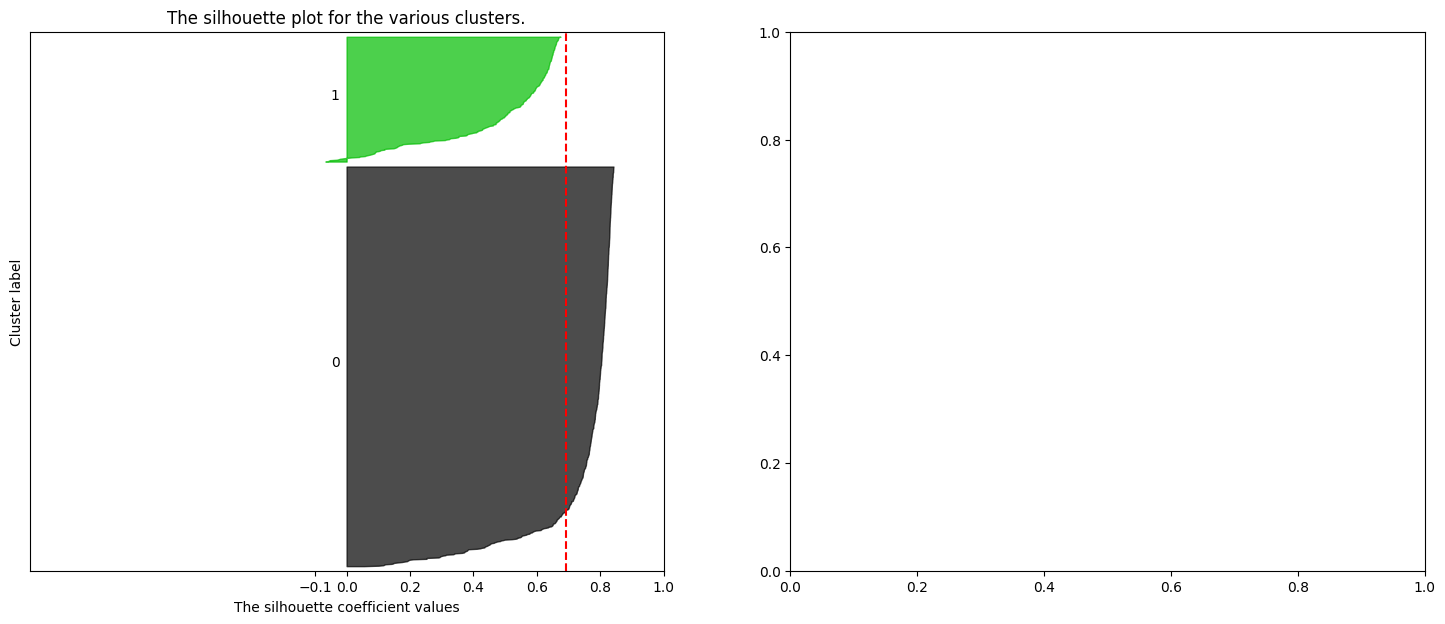

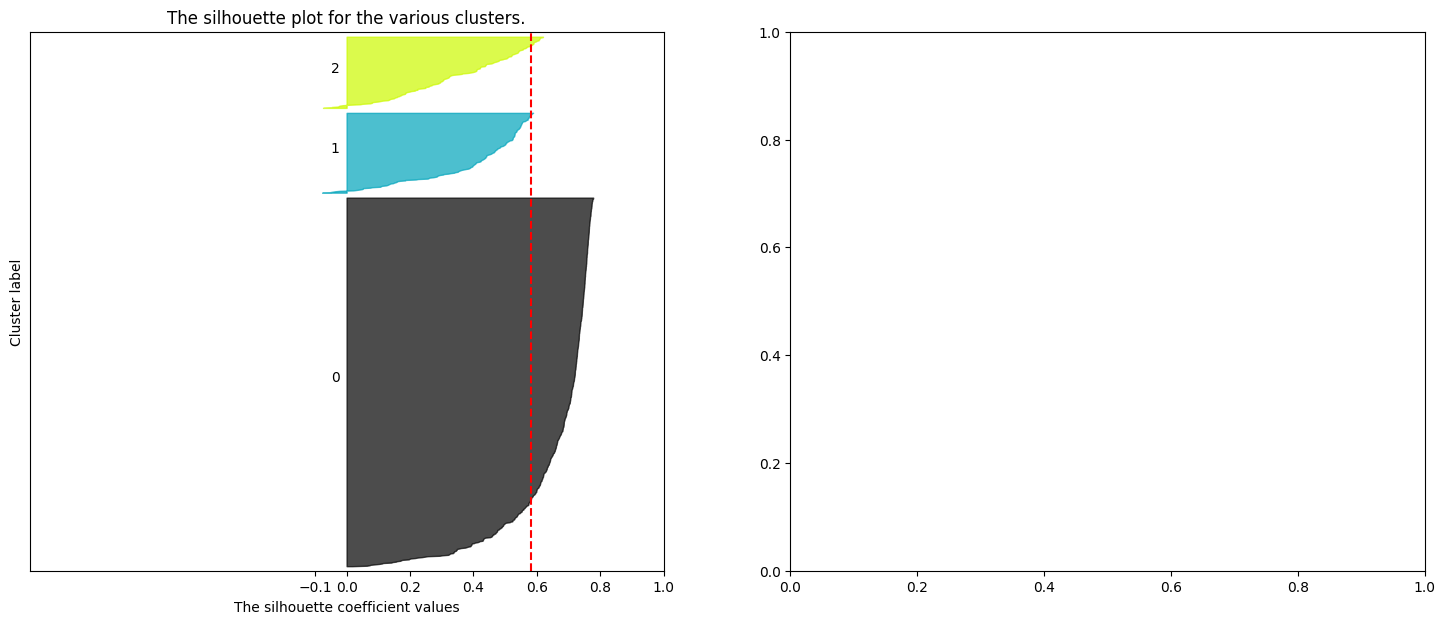

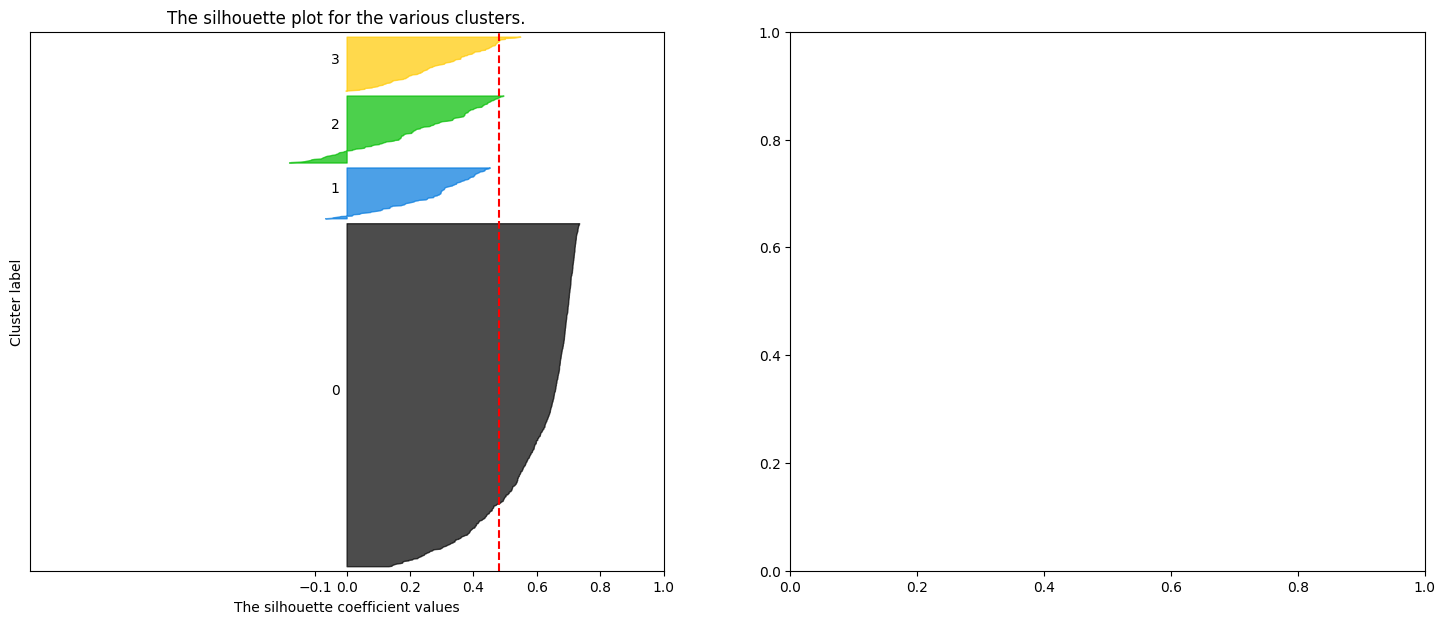

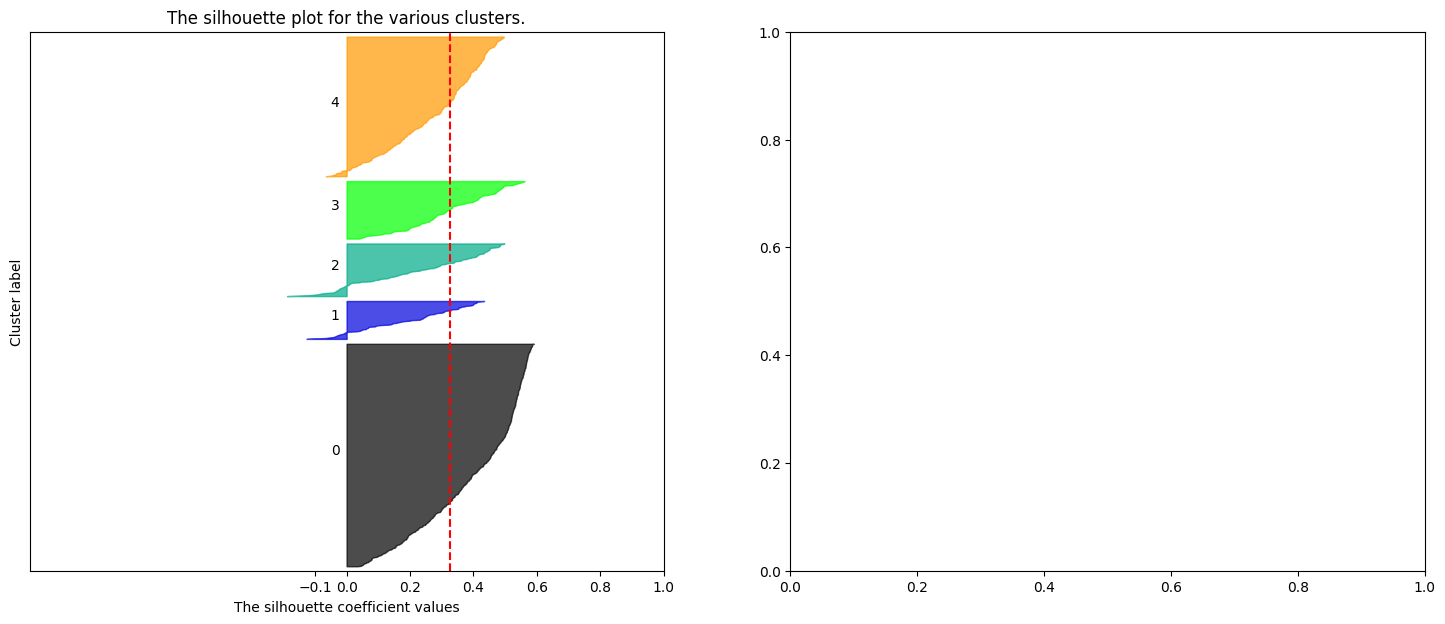

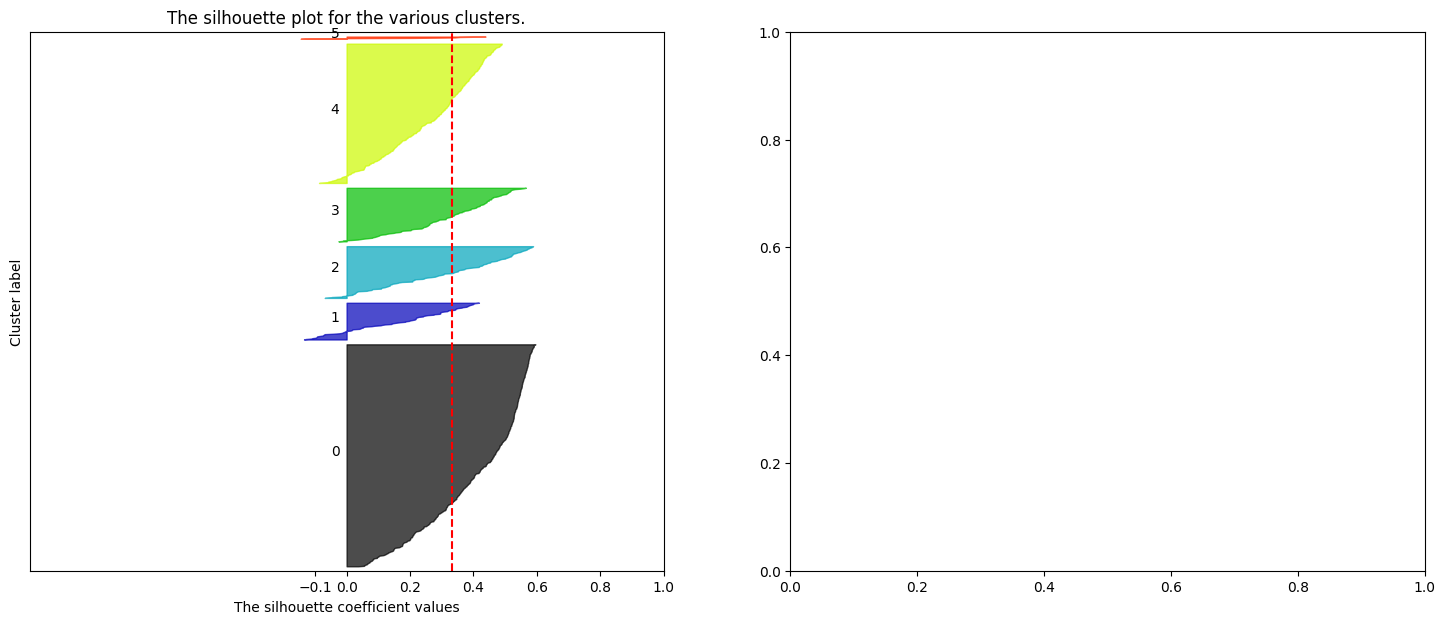

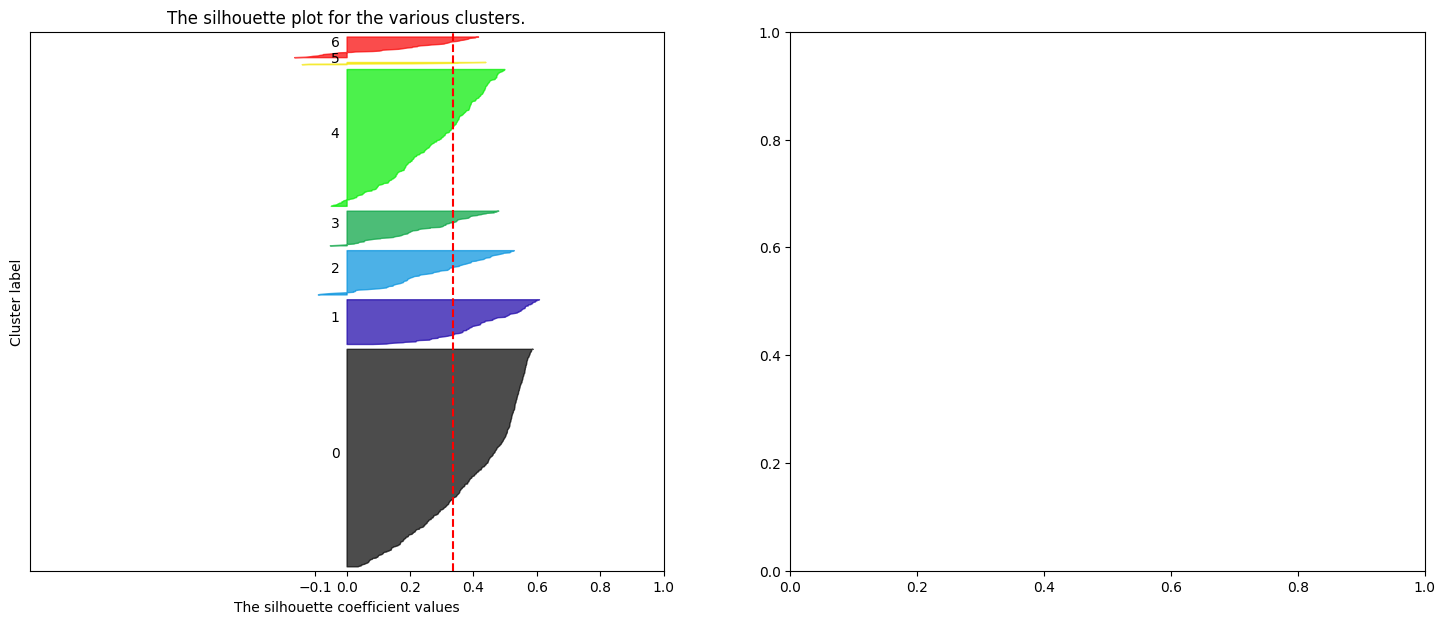

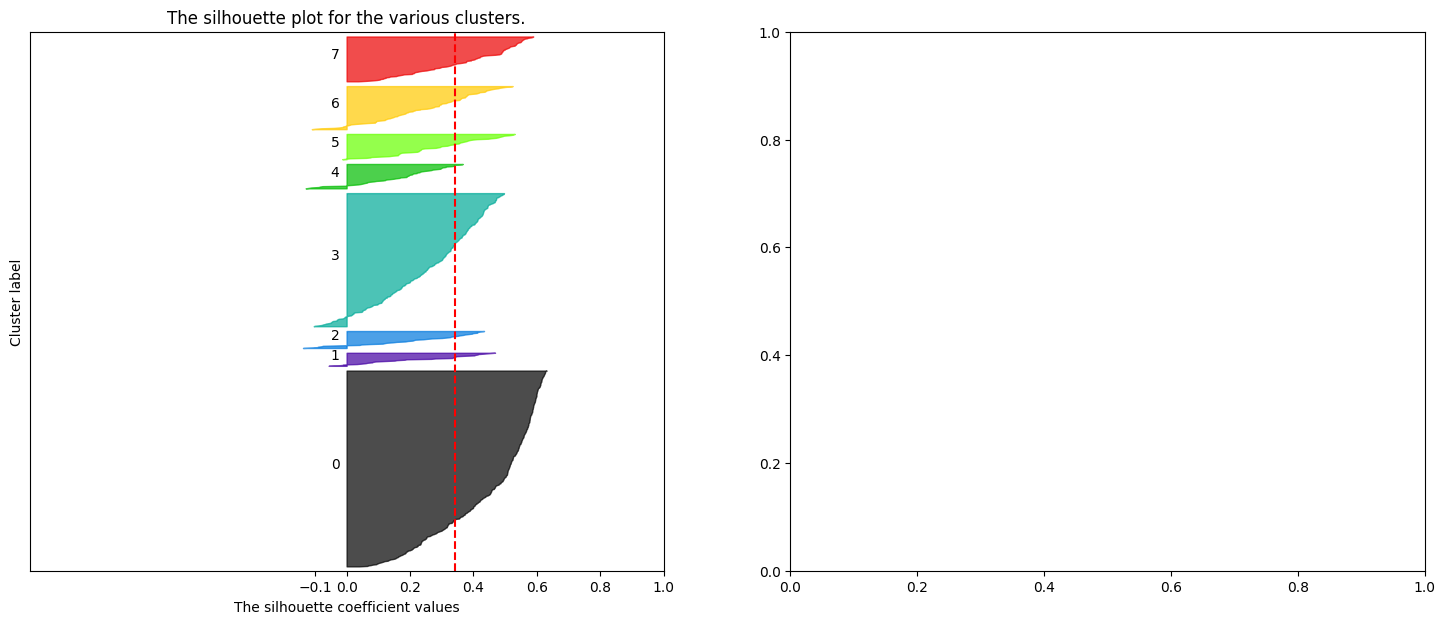

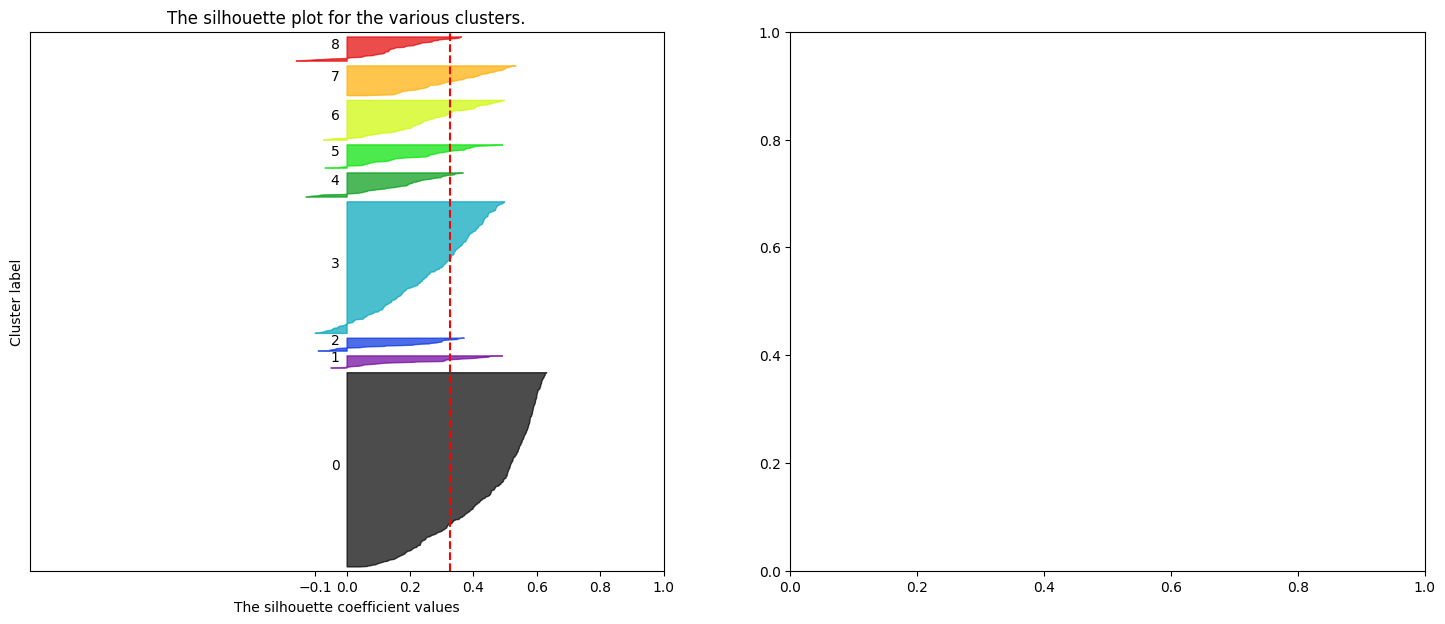

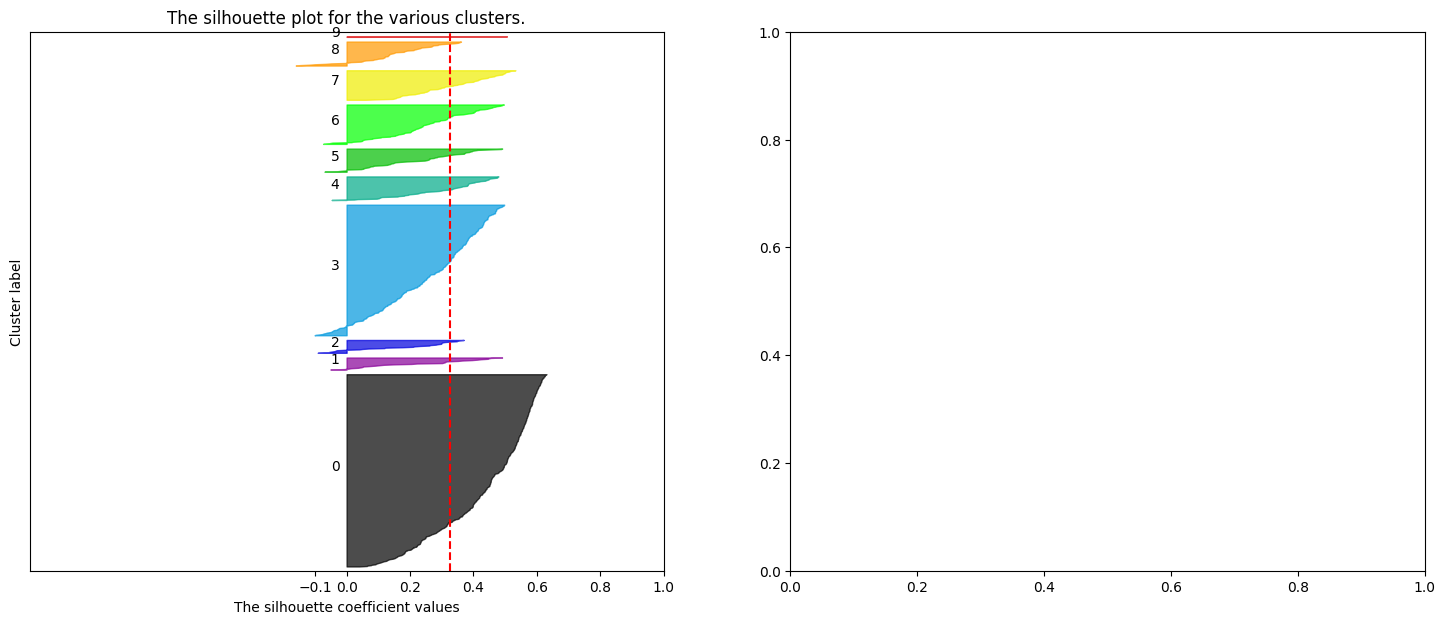

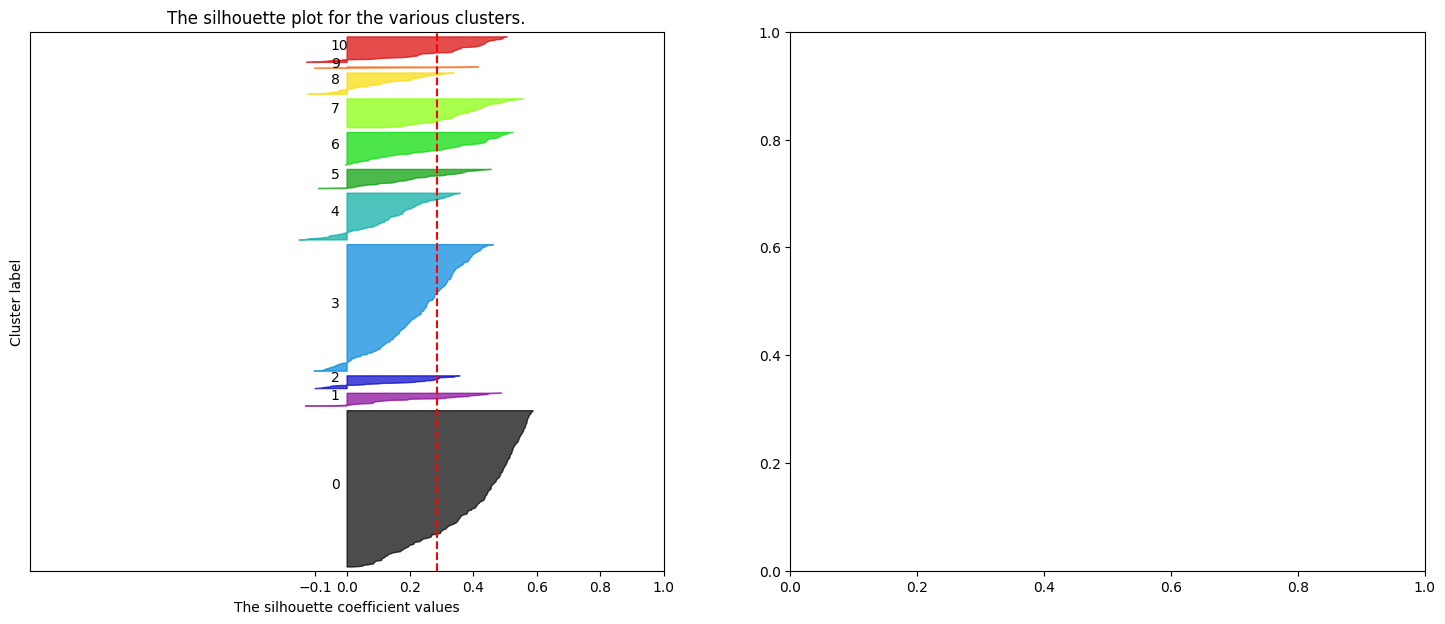

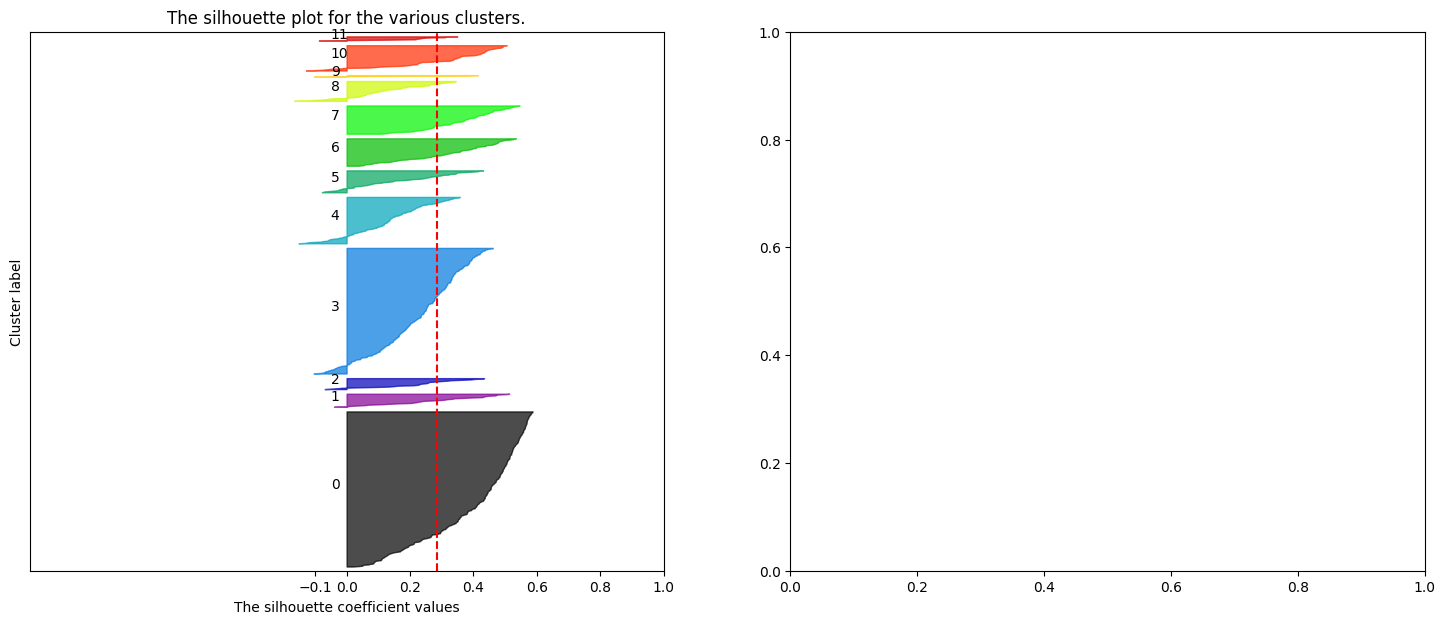

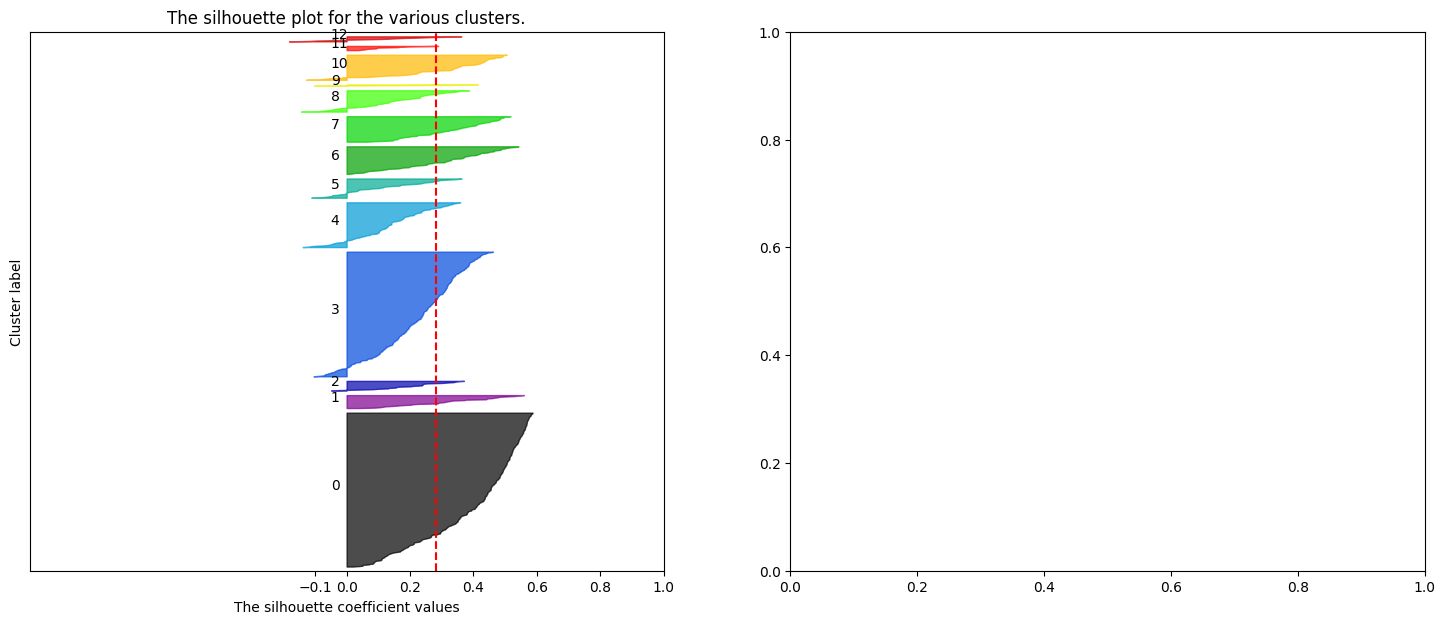

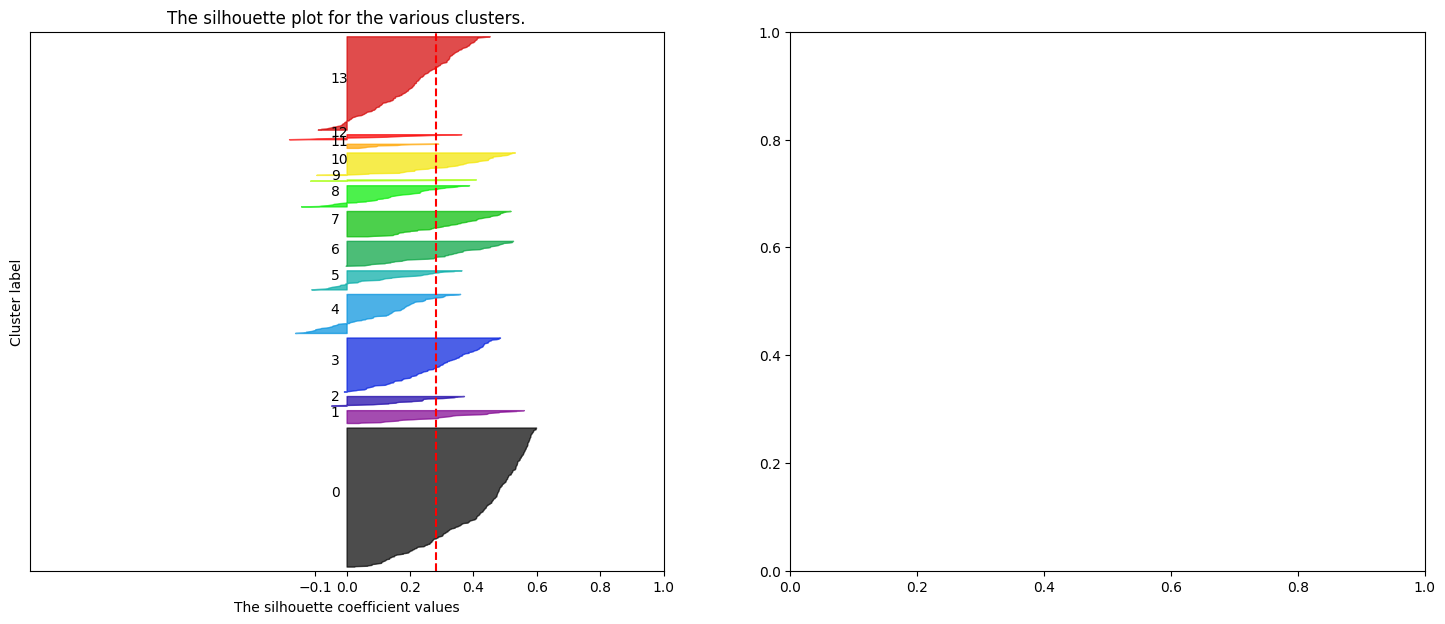

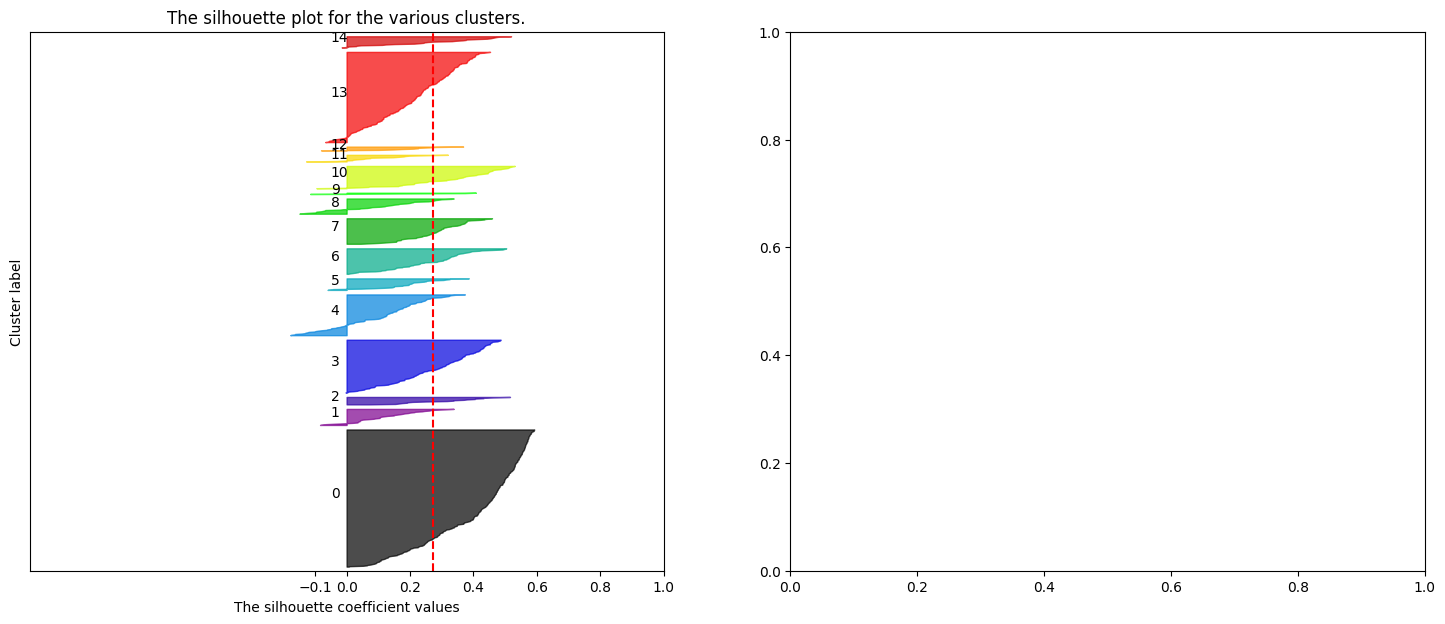

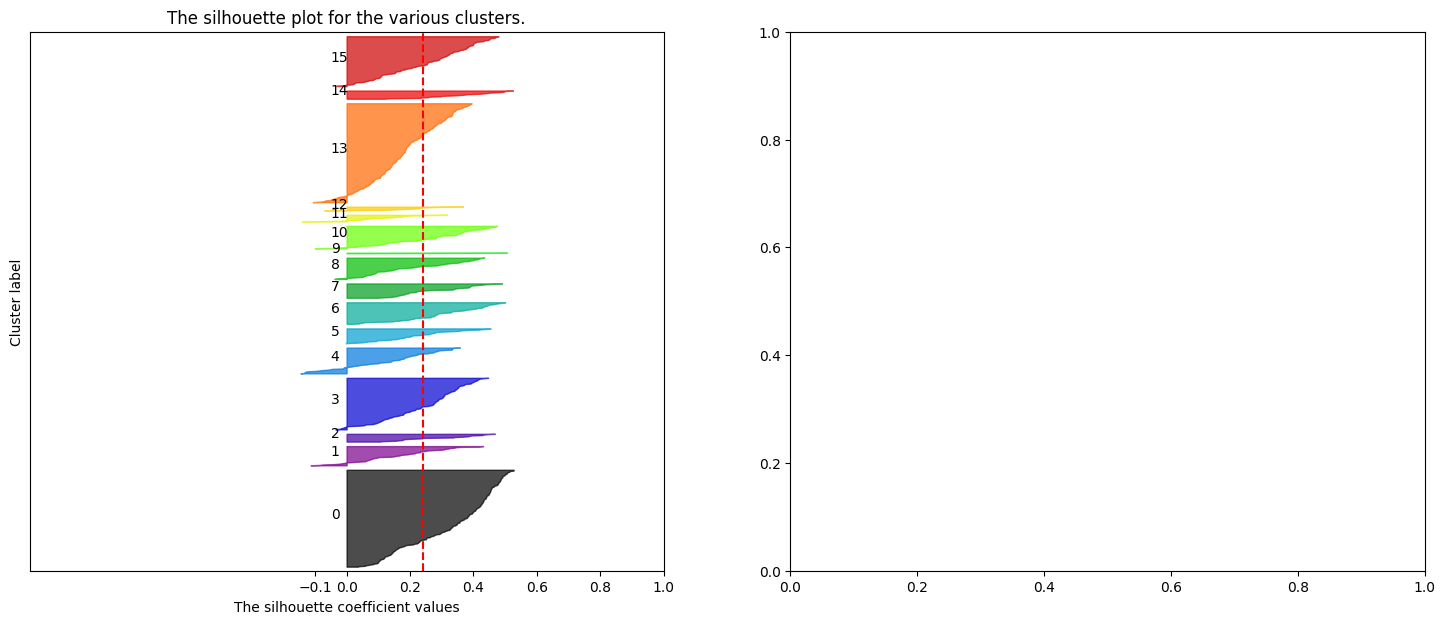

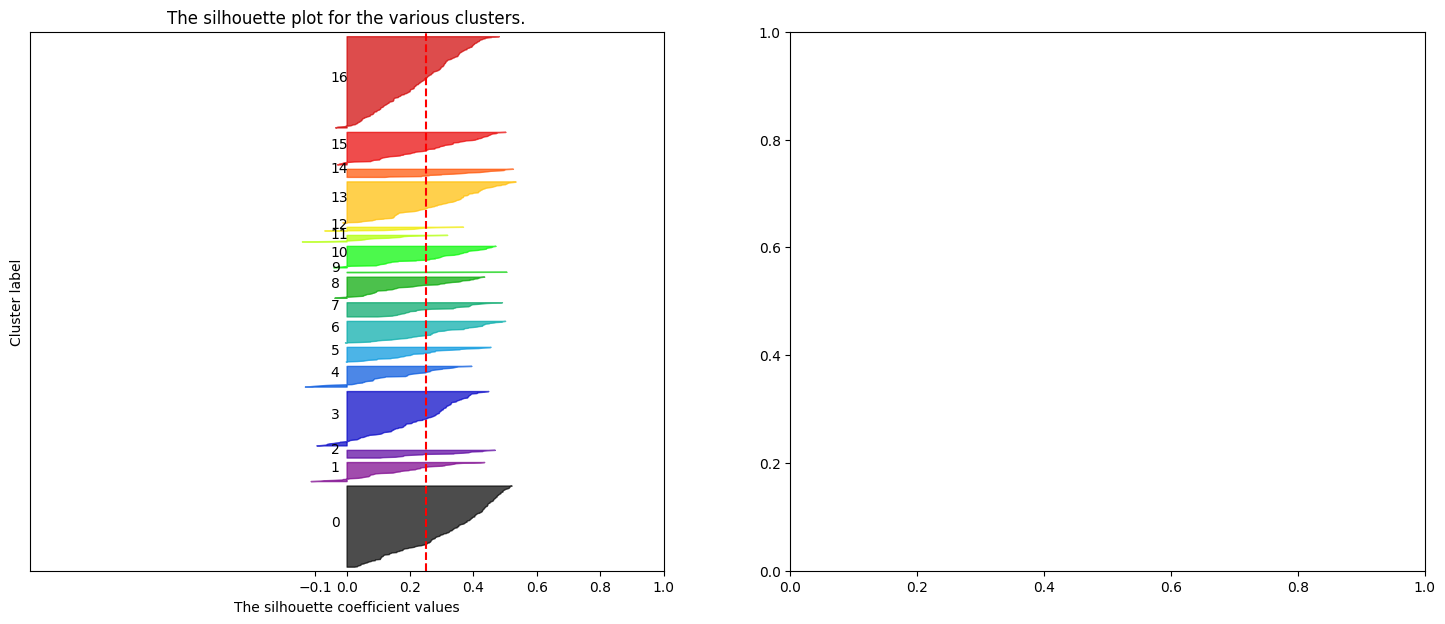

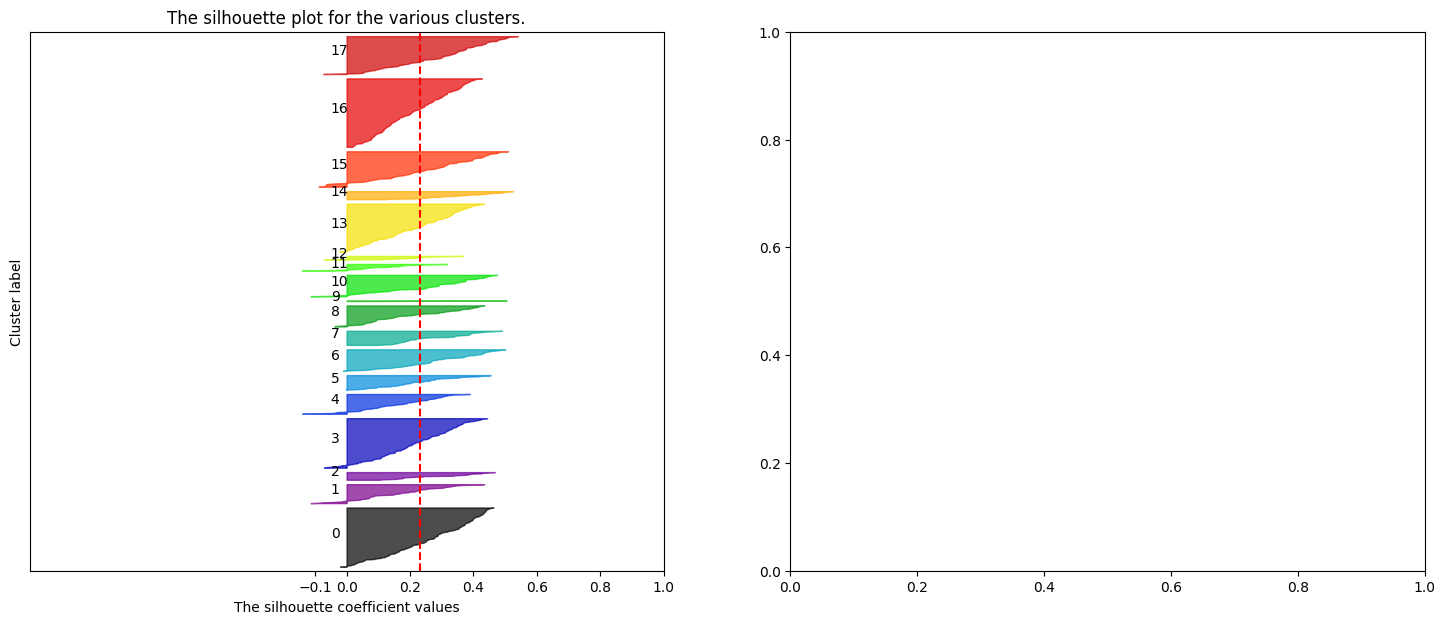

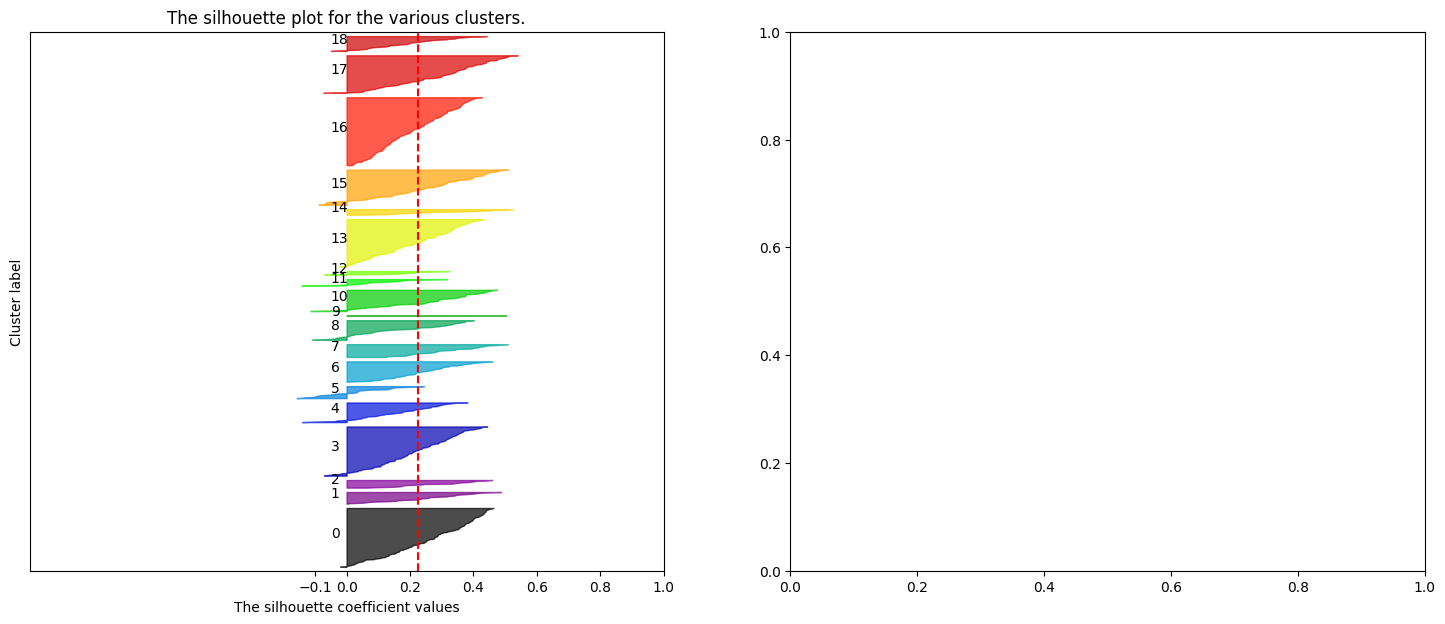

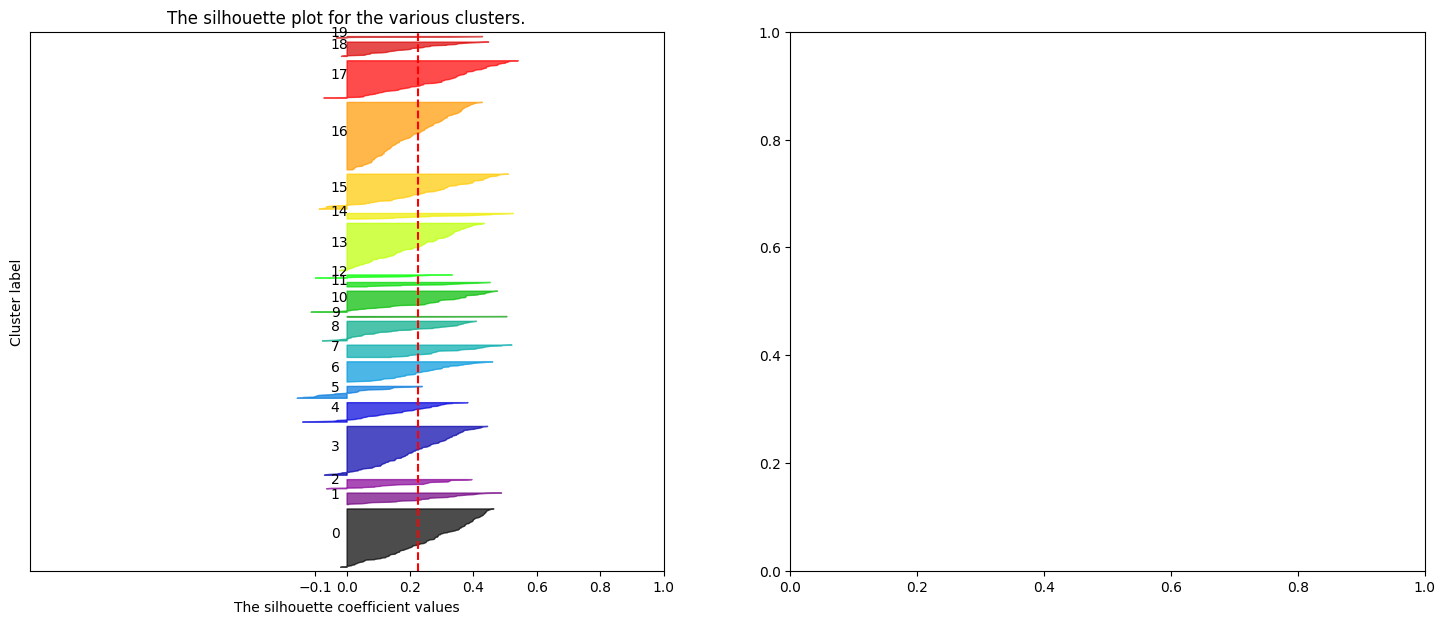

In [21]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import fastf1

#sample data
dirname = '../data/1_Sakhir'
race = fastf1.get_session(2023, 'Monaco Grand Prix', 'R')
race.load()
X = race.laps
rows_to_remove = X.index[X['PitInTime'].notnull()].tolist()
X = X.drop(rows_to_remove, axis = 0)
rows_to_remove = X.index[X['PitOutTime'].notnull()].tolist()
X = X.drop(rows_to_remove, axis = 0)
cols_to_remove =['Time', 'DriverNumber','PitOutTime','PitInTime', 'Sector1SessionTime', 
                        'Sector2SessionTime', 'Sector3SessionTime', 'IsPersonalBest',
                        'FreshTyre','LapStartTime','LapStartDate', 'Deleted',
                        'DeletedReason','FastF1Generated','IsAccurate']
X = X.drop(cols_to_remove, axis = 1)
X['TrackStatus'] = X['TrackStatus'].astype('float') #I hate this
#drop rows where track status is not 1, i.e. the lap is not a 'racing' lap
rows_to_remove = X.index[X['TrackStatus'] != 1].tolist()
X = X.drop(rows_to_remove, axis = 0)


#drop rows with missing data because i cant think of something better
X = X.dropna(axis=0)
#drop trackStatus as well after i used i to remove the rows i wanted
X = X.drop('TrackStatus', axis = 1)
#Convert timedelta64 to seconds
cols_to_change = ['LapTime','Sector1Time',
              'Sector2Time', 'Sector3Time']
for col in cols_to_change:
    X[col] = X[col].dt.total_seconds()
X = X.reset_index()
cols = ['LapTime', 'Sector1Time',
              'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2',
              'SpeedFL', 'SpeedST']
X = X[cols]

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10,
                    11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   

plt.show()
